# John Wang (are2ag@virginia.edu) DS 5001 Spring 2023

# Analysis

# Set-Up

In [1]:
import pandas as pd
import os
import datetime
import numpy as np
import nltk
from scipy.spatial.distance import pdist
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.linalg import norm
from scipy.linalg import eigh
import plotly_express as px
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from scipy.linalg import norm
from gensim.models import word2vec
from sklearn.manifold import TSNE
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from scipy.stats import pearsonr
import sqlite3
import re
from IPython.display import HTML
import plotly.figure_factory as ff
import kaleido
import plotly.io as pio

colors = "YlGnBu"

In [2]:
data_home = "C:/Users/johnw/Box/Wang_John_DS5001_Final/0_RAW_DATA"
table_home = "C:/Users/johnw/Box/Wang_John_DS5001_Final/3_TABLES"
figure_home = "C:/Users/johnw/Box/Wang_John_DS5001_Final/4_FIGURES"

In [3]:
OHCO = ['district_id', 'date_order', 'speaker_num','sentence_num', 'token_num']

# Importing Core Tables

In [4]:
TRANSCRIPT_LIB = pd.read_csv(f"{table_home}/TRANSCRIPT_LIB.csv").set_index(['district_id', 'date_order'])
TRANSCRIPT_CORPUS = pd.read_csv(f"{table_home}/TRANSCRIPT_CORPUS.csv").set_index(OHCO)
TRANSCRIPT_VOCAB = pd.read_csv(f"{table_home}/TRANSCRIPT_VOCAB.csv").set_index('term_str')

# Basic Statistics of Document

In [5]:
TRANSCRIPT_CORPUS_DISTRICT_ID_DATE = pd.DataFrame(TRANSCRIPT_CORPUS.groupby(OHCO[:2]).term_str.apply(lambda x: x.str.cat(sep=' ')))

In [6]:
TRANSCRIPT_CORPUS_DISTRICT_ID_DATE['document_length']= TRANSCRIPT_CORPUS_DISTRICT_ID_DATE['term_str'].str.count(' ')

In [7]:
TRANSCRIPT_CORPUS_DISTRICT_ID_DATE['document_length'].mean()

3057.8445595854923

# Across districts, were there school board meetings that were "similar"? Within districts, were school board meetings "similar" across time points?

One approach of addressing this research question is to understand how school district's board meetings cluster together. By grouping these school board meetings together, we set ourselves up to have a high-level understanding of the similarities between school districts that, on the surface, may appear very different from commonly available district characteristic data. In addition, it may be valuable to understand whether the same school district continued to have similar content across time points. Perhaps this is indicative of lingering, unresolved concerns within the district if the content continued, or if the topic completely shifts, an indication of some sort of resolution to prior concerns.

To accomplish this task, we need the following things created:

1) TF-IDF of our bag of interest ('district_id') - we opt to use the "max" count TF and "standard" IDF methods.

2) Doc-Pair tables for school districts 

3) Select distance measure - we opt for the "cosine similarity" approach since our transcripts vary greatly in length and cosine-similarity is already normalized dot product of two vectors. In addition, the interpretability of -1 to 1 may allow us to understand whether school districts are "opposite," "completely unrelated," or "similar". 

4) Performing Hierarchical Agglomerative Clustering + Identification of a linkage method - we theorize that there is a huge potential for noise since our data are from transcripts of school board meetings. The school board meetings had substantial variation in the quality of audio, which may translate to variation in the precise transcription of the words by otter.ai. In addition, the contents of these transcripts vary greatly with some school board meetings going on for substantial periods of time with many speakers, while other transcripts consisting of one or two unique speakers. At the same time, language models may benefit from more spherical methods, so we ultimately opt for "Ward" as our linkage method.

### TF-IDF

In [8]:
#Setting up bag of words function
def generate_bow(bag_input, token_df):
    
    BOW = token_df.groupby(bag_input+['term_str']).term_str.count().to_frame('n')
    return BOW

In [9]:
#Generating bag of words for our school districts
DISTRICTS = OHCO[:1]
DISTRICTS_DATE = OHCO[:2]
DISTRICTS_DATES_BOW = generate_bow(DISTRICTS_DATE, TRANSCRIPT_CORPUS)

In [10]:
#Setting up our TF-IDF function
def generate_tfidf(bow_input, tf_method):
    
    #Converts BOW into a DTM
    DTCM = bow_input.n.unstack().fillna(0).astype('int')
    
    #Computes TF
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log2(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    TF = TF.T   
    
    #Computes DF
    DF = DTCM.astype('bool').sum()
    
    #Computes IDF
    N = DTCM.shape[0]
    IDF = np.log2(N / DF)
        
    #Computes TF-IDF
    TFIDF = TF*IDF
    return TFIDF

In [11]:
#Generating DISTRICTS TFIDF using Max count and the "Standard" IDF
districts_dates_max_tfidf = generate_tfidf(DISTRICTS_DATES_BOW, 'max')

In [12]:
#Collapsing TF-IDF into our school district bag
district_dates_TFIDF = districts_dates_max_tfidf.groupby(OHCO[:2]).sum()

In [13]:
#Preparing TF-IDF to be added to the CORPUS tables
district_dates_TFIDF_termstr = pd.DataFrame(district_dates_TFIDF.max()).reset_index()
district_dates_TFIDF_termstr = district_dates_TFIDF_termstr.rename(columns={district_dates_TFIDF_termstr.columns[1]: "district_dates_TFIDF"})
TRANSCRIPT_CORPUS = TRANSCRIPT_CORPUS.reset_index().merge(district_dates_TFIDF_termstr, on='term_str', how='left').set_index(OHCO)

In [14]:
#Preparing TF-IDF to be added to the VOCAB tables
TRANSCRIPT_VOCAB['district_dates_TFIDF'] = district_dates_TFIDF.max()

### DF-IDF

In [15]:
def generate_dfidf(bow_input, tf_method):
    
    #Converts BOW into a DTM
    DTCM = bow_input.n.unstack().fillna(0).astype('int')
    
    #Computes TF
    if tf_method == 'sum':
        TF = DTCM.T / DTCM.T.sum()
    elif tf_method == 'max':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'log':
        TF = np.log2(1 + DTCM.T)
    elif tf_method == 'raw':
        TF = DTCM.T
    elif tf_method == 'double_norm':
        TF = DTCM.T / DTCM.T.max()
    elif tf_method == 'binary':
        TF = DTCM.T.astype('bool').astype('int')
    TF = TF.T   
    
    #Computes DF
    DF = DTCM.astype('bool').sum()
    
    #Computes IDF
    N = DTCM.shape[0]
    IDF = np.log2(N / DF)
        
    #Computes TF-IDF
    DFIDF = DF*IDF
    return DFIDF

In [16]:
#Generating DISTRICTS TFIDF using Max count and the "Standard" IDF
districts_dates_max_dfidf = generate_dfidf(DISTRICTS_DATES_BOW, 'max')

In [17]:
#Preparing DF-IDF to be added to the VOCAB tables
TRANSCRIPT_VOCAB['districts_dates_max_dfidf'] = districts_dates_max_dfidf.max()

### Doc-Pair Tables

In [18]:
DISTRICT_DATE_PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([TRANSCRIPT_LIB.index.tolist(), TRANSCRIPT_LIB.index.tolist()])).reset_index()
DISTRICT_DATE_PAIRS = DISTRICT_DATE_PAIRS[DISTRICT_DATE_PAIRS.level_0 < DISTRICT_DATE_PAIRS.level_1].set_index(['level_0','level_1'])
DISTRICT_DATE_PAIRS.index.names = ['doc_a', 'doc_b']

In [19]:
DISTRICT_DATE_PAIRS

Empty DataFrame
Columns: []
Index: [((1, 1), (1, 2)), ((1, 1), (2, 1)), ((1, 1), (2, 2)), ((1, 1), (101, 1)), ((1, 1), (101, 2)), ((1, 1), (3, 1)), ((1, 1), (3, 2)), ((1, 1), (4, 1)), ((1, 1), (4, 2)), ((1, 1), (5, 1)), ((1, 1), (5, 2)), ((1, 1), (7, 1)), ((1, 1), (7, 2)), ((1, 1), (8, 1)), ((1, 1), (8, 2)), ((1, 1), (10, 1)), ((1, 1), (10, 2)), ((1, 1), (11, 1)), ((1, 1), (11, 2)), ((1, 1), (12, 1)), ((1, 1), (13, 1)), ((1, 1), (13, 2)), ((1, 1), (15, 1)), ((1, 1), (15, 2)), ((1, 1), (16, 1)), ((1, 1), (16, 2)), ((1, 1), (17, 1)), ((1, 1), (17, 2)), ((1, 1), (18, 1)), ((1, 1), (18, 2)), ((1, 1), (19, 1)), ((1, 1), (19, 2)), ((1, 1), (104, 1)), ((1, 1), (104, 2)), ((1, 1), (136, 1)), ((1, 1), (136, 2)), ((1, 1), (21, 1)), ((1, 1), (21, 2)), ((1, 1), (22, 1)), ((1, 1), (202, 1)), ((1, 1), (106, 1)), ((1, 1), (106, 2)), ((1, 1), (107, 1)), ((1, 1), (24, 1)), ((1, 1), (24, 2)), ((1, 1), (25, 1)), ((1, 1), (108, 1)), ((1, 1), (26, 1)), ((1, 1), (26, 2)), ((1, 1), (27, 1)), ((1, 1), (28, 1)), ((1, 1), (28, 2)), ((1, 1), (29, 1)), ((1, 1), (29, 2)), ((1, 1), (109, 1)), ((1, 1), (30, 1)), ((1, 1), (30, 2)), ((1, 1), (31, 1)), ((1, 1), (31, 2)), ((1, 1), (32, 1)), ((1, 1), (135, 1)), ((1, 1), (135, 2)), ((1, 1), (33, 1)), ((1, 1), (33, 2)), ((1, 1), (34, 1)), ((1, 1), (34, 2)), ((1, 1), (110, 1)), ((1, 1), (110, 2)), ((1, 1), (111, 1)), ((1, 1), (35, 1)), ((1, 1), (35, 2)), ((1, 1), (36, 1)), ((1, 1), (36, 2)), ((1, 1), (37, 1)), ((1, 1), (37, 2)), ((1, 1), (38, 1)), ((1, 1), (39, 1)), ((1, 1), (39, 2)), ((1, 1), (40, 1)), ((1, 1), (41, 1)), ((1, 1), (41, 2)), ((1, 1), (112, 1)), ((1, 1), (42, 1)), ((1, 1), (42, 2)), ((1, 1), (113, 1)), ((1, 1), (113, 2)), ((1, 1), (43, 1)), ((1, 1), (43, 2)), ((1, 1), (44, 1)), ((1, 1), (44, 2)), ((1, 1), (46, 1)), ((1, 1), (46, 2)), ((1, 1), (49, 1)), ((1, 1), (48, 1)), ((1, 1), (50, 1)), ((1, 1), (51, 1)), ((1, 1), (51, 2)), ((1, 1), (52, 1)), ((1, 1), (52, 2)), ((1, 1), (137, 1)), ...]

[18528 rows x 0 columns]

### Computing Cosine Distance

In [20]:
DISTRICT_DATE_PAIRS['cosine'] = pdist(district_dates_TFIDF, 'cosine')

In [21]:
DISTRICT_DATE_PAIRS.sort_values('cosine').head(20).style.background_gradient(colors)

### Hierarchical Agglomerative Clustering

In [22]:
#Adding Labels
TRANSCRIPT_LIB['label'] = TRANSCRIPT_LIB.district_name + ': ' + TRANSCRIPT_LIB.index.get_level_values('date_order').astype('str')

In [23]:
def hca(sims, linkage_method='complete', color_thresh=.3, figsize=(10, 10), fignum=0, figname="test"):
    tree = sch.linkage(sims, method=linkage_method)
    labels = TRANSCRIPT_LIB.label.values
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=3.5)
    plt.savefig(f"{figure_home}/FIG_"+str(fignum)+"_"+figname)

    # Extract the clusters
    clusters = sch.fcluster(tree, t=color_thresh, criterion='distance')
    cluster_labels = pd.Series(clusters, index=TRANSCRIPT_LIB.index)

    # Create a dictionary with cluster labels as keys and a list of districts as values
    cluster_dict = {}
    for label in np.unique(clusters):
        cluster_dict[label] = list(cluster_labels[cluster_labels == label].index)
    
    return cluster_dict

<Figure size 640x480 with 0 Axes>

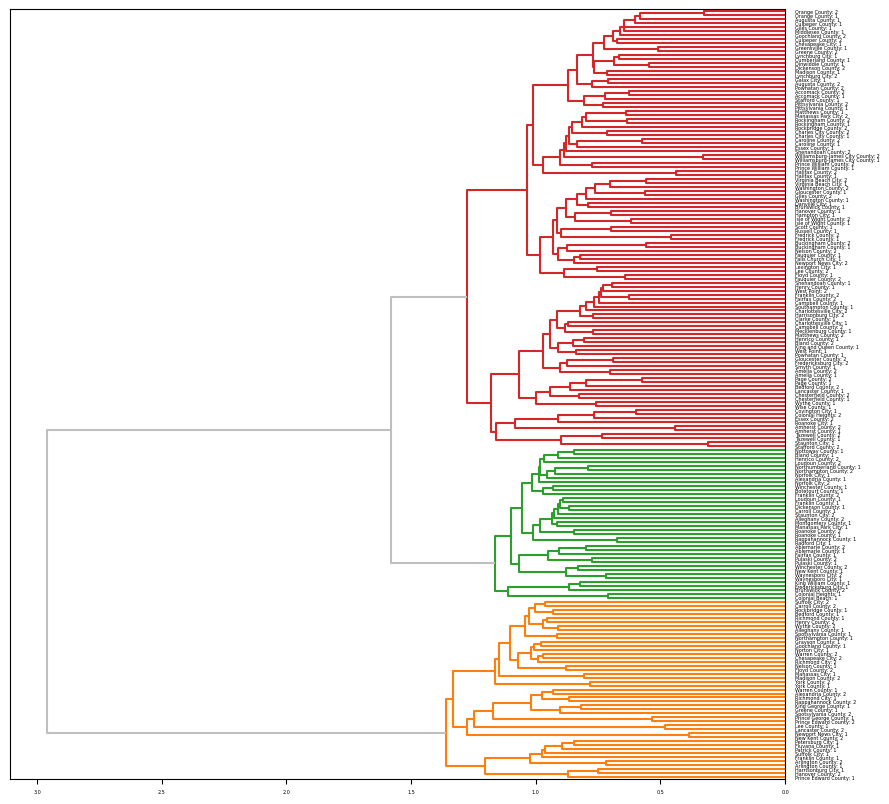

In [24]:
cluster_dict = hca(DISTRICT_DATE_PAIRS.cosine, linkage_method='ward', color_thresh=1.5, fignum=1, figname="HAC_TRANSCRIPTS_UNADJUSTED")

In [25]:
#Extracting the data from a dictionary to prepare for merger back with TRANSCRIPT_LIB
dendrogram_cluster = pd.DataFrame(columns=['dendrogram_cluster', 'district_id', 'date_order'])

for cluster in range(1,len(cluster_dict)+1):
    for district_id_date_order_pair in range(len(cluster_dict[cluster])):
        temp_df = pd.DataFrame(columns=['dendrogram_cluster', 'district_id', 'date_order'])
        new_data = [cluster, cluster_dict[cluster][district_id_date_order_pair][0], cluster_dict[cluster][district_id_date_order_pair][1]]
        new_row = pd.DataFrame([new_data], columns=['dendrogram_cluster', 'district_id', 'date_order'])
        dendrogram_cluster = pd.concat([dendrogram_cluster, new_row], ignore_index=True)

dendrogram_cluster = dendrogram_cluster.set_index(['district_id','date_order'])

In [26]:
#Merging TRANSCRIPT_LIB with the dendrogram cluster
TRANSCRIPT_LIB = pd.merge(TRANSCRIPT_LIB, dendrogram_cluster, left_index=True, right_index=True)

### How many school districts are relatively similar [as defined by being in the same cluster]?

In [27]:
TRANSCRIPT_LIB['dendrogram_cluster'].value_counts()

3    110
1     45
2     38
Name: dendrogram_cluster, dtype: int64

### How many school districts have all district_id's in the same cluster?

In [28]:
TRANSCRIPT_LIB.groupby('district_id')['dendrogram_cluster'].nunique().eq(1)

district_id
1       True
2       True
3      False
4       True
5       True
       ...  
137     True
143     True
144    False
202     True
207     True
Name: dendrogram_cluster, Length: 114, dtype: bool

In [29]:
counts = (TRANSCRIPT_LIB.groupby('district_id')['dendrogram_cluster']
                    .nunique()
                    .value_counts()
                    .loc[1])

In [30]:
#82 districts have the same cluster 
counts

82

### Which school districts have district_id's that are in different clusters?

In [31]:
counts = TRANSCRIPT_LIB.groupby('district_id')['dendrogram_cluster'].nunique()
not_unique_counts = counts[counts != 1]

In [32]:
not_unique_counts

district_id
3      2
10     2
11     2
13     2
18     2
26     2
29     2
31     2
33     2
37     2
39     2
42     2
43     2
44     2
51     2
52     2
56     2
62     2
63     2
65     2
78     2
81     2
97     2
101    2
106    2
110    2
113    2
117    2
126    2
135    2
136    2
144    2
Name: dendrogram_cluster, dtype: int64

# Are previous findings of school board meeting similarities robust to an adjustment for a latent semantic structure? How might lexical differences illustrate how school board meetings are similar or different?

The previous approach of addressing the research questions: 1) Across districts, were there school board meetings that were "similar"? 2) Within districts, were school board meetings "similar" across time points? leveraged a simple clustering approach. Unfortunately, the trade-off with such an approach is that the same content but with different word choices may appera orthogonal, or completely unrelated.

One possible solution is to capture 'meaning'. In particular, some words may occur with other words but never appear together because they are synonyms- we may be able to capture a latent semantic structure instead through Principal Component Analysis. We can create a reduced version of the document-term matrix and view the documents in component space, allowing us to examine whether school board meetings are also similar in the underlying latent semantic structure.

In addition, PCA also generates a table of loadings, the relationship betweeen terms and components, to examine how lexical features may contribute to the differences across school board meetings.

To accomplish this task, we need the following things created:

1) Create a DOC table

2) A reduced TF-IDF table of our bag of interest ('district_id') - we opt to use the top 1000 significant nouns, verbs, and adjectives.

3) PCA Set-up: Normalize doc vector lengths [not term vector variance], center term vectors,compute covariance matrices, decompose the matrix, and convert the eigen-vector/values to dataframes.

4) Select Principal Components

5) Project Components onto Vocabulary

6) Project Documents onto Components

7) Visualization Tools

### Create DOC Table

In [33]:
#Merging LIB into the TFIDF Index to create a DOC table
districts_dates_max_tfidf = pd.merge(districts_dates_max_tfidf, TRANSCRIPT_LIB, left_index=True, right_index=True)
TRANSCRIPT_DTM = districts_dates_max_tfidf.reset_index()
TRANSCRIPT_DOC = TRANSCRIPT_DTM.groupby(['district_id','date_order']).sum()
TRANSCRIPT_DOC = pd.merge(TRANSCRIPT_DOC, TRANSCRIPT_LIB, left_index=True, right_index=True)

### Reduced TF-IDF Table

In [34]:
#Reducing the vocab down to the top 1000 significant nouns, verbs, and adjectives
VSHORT = TRANSCRIPT_VOCAB[TRANSCRIPT_VOCAB.max_pos.isin(['NN', 'VB', 'JJ'])].sort_values('district_dates_TFIDF', ascending=False).head(1000)

In [35]:
#Restricting the TFIDF to those that are the top 1000 significant nouns, verbs, and adjectives
districts_dates_max_tfidf = districts_dates_max_tfidf[VSHORT.index]

### PCA Set-Up

In [36]:
#Normalize Document Vector Lengths
districts_dates_max_tfidf_L2 = (districts_dates_max_tfidf.T / norm(districts_dates_max_tfidf, 2, axis=1)).T

In [37]:
#Center Term Vectors
districts_dates_max_tfidf_L2 = districts_dates_max_tfidf_L2 - districts_dates_max_tfidf_L2.mean()

In [38]:
#Compute Covariance Matrix
TRANSCRIPT_COVARIANCE = districts_dates_max_tfidf_L2.T.dot(districts_dates_max_tfidf_L2) / (districts_dates_max_tfidf_L2.shape[0] - 1)

In [39]:
#Decompose the Matrix
eig_vals, eig_vecs = eigh(TRANSCRIPT_COVARIANCE)

In [40]:
#Convert eigen data to dataframes
EIG_VEC = pd.DataFrame(eig_vecs, index=TRANSCRIPT_COVARIANCE.index, columns=TRANSCRIPT_COVARIANCE.index)
EIG_VAL = pd.DataFrame(eig_vals, index=TRANSCRIPT_COVARIANCE.index, columns=['eig_val'])
EIG_VAL.index.name = 'term_str'

### Select Principal Components

In [41]:
#Combine eigenvalues and eigenvectors
EIG_PAIRS = EIG_VAL.join(EIG_VEC.T)

In [42]:
#Compute explained variance
EIG_PAIRS['exp_var'] = np.round((EIG_PAIRS.eig_val / EIG_PAIRS.eig_val.sum()) * 100, 2)

<AxesSubplot:xlabel='term_str'>

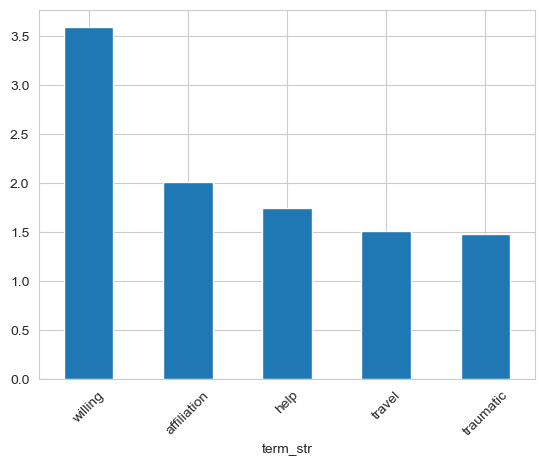

In [185]:
#Display explained variance
EIG_PAIRS.exp_var.sort_values(ascending=False).head(5).plot.bar(rot=45)

In [44]:
#Based on the explained variance, I will select the first three components
TRANSCRIPT_COMPS = EIG_PAIRS.sort_values('exp_var', ascending=False).head(3).reset_index(drop=True)
TRANSCRIPT_COMPS.index.name = 'comp_id'
TRANSCRIPT_COMPS.index = ["PC{}".format(i) for i in TRANSCRIPT_COMPS.index.tolist()]
TRANSCRIPT_COMPS.index.name = 'pc_id'

In [45]:
TRANSCRIPT_COMPS

eig_val    french  submission  conditioningventilation     store  \
pc_id                                                                      
PC0    0.032764 -0.030902   -0.022300                -0.033745 -0.012700   
PC1    0.018368  0.003305   -0.003336                -0.014284 -0.012432   
PC2    0.015991 -0.014685    0.003115                -0.043055 -0.006109   

          grant      wise  deadline     dance     dress  ...  pedophile  \
pc_id                                                    ...              
PC0    0.022278 -0.000657 -0.016467 -0.008367 -0.027833  ...   0.000507   
PC1   -0.021023 -0.011841  0.001296 -0.004167  0.065791  ...   0.014543   
PC2   -0.020213 -0.049754 -0.000589 -0.022532  0.037242  ...  -0.007089   

         impact    annual  internet  traumatic    travel      help  \
pc_id                                                                
PC0    0.039564  0.008515  0.014778   0.006948  0.023069  0.059814   
PC1   -0.030585  0.011059  0.008105   0.008596 -0.012625 -0.012477   
PC2    0.021122  0.015778  0.032070  -0.007198  0.014866  0.045295   

       affiliation   willing  exp_var  
pc_id                                  
PC0       0.008915  0.052318     3.59  
PC1       0.001456  0.010361     2.01  
PC2       0.037468  0.006940     1.75  

[3 rows x 1002 columns]

### Project Components onto Vocabulary

In [46]:
TRANSCRIPT_LOADINGS = TRANSCRIPT_COMPS[TRANSCRIPT_COVARIANCE.index].T
TRANSCRIPT_LOADINGS.index.name = 'term_str'

In [47]:
TRANSCRIPT_LOADINGS.head(3).style.background_gradient(cmap=colors)


In [48]:
#Attaching the top 5 words with each principal component
top_terms = []
for i in range(3):
    for j in [0, 1]:
        comp_str = ' '.join(TRANSCRIPT_LOADINGS.sort_values(f'PC{i}', ascending=bool(j)).head(10).index.to_list())
        top_terms.append((f"PC{i}", j, comp_str))
TRANSCRIPT_COMP_GLOSS = pd.DataFrame(top_terms).set_index([0,1]).unstack()
TRANSCRIPT_COMP_GLOSS.index.name = 'comp_id'
TRANSCRIPT_COMP_GLOSS.columns = TRANSCRIPT_COMP_GLOSS.columns.droplevel(0) 
TRANSCRIPT_COMP_GLOSS = TRANSCRIPT_COMP_GLOSS.rename(columns={0:'pos', 1:'neg'})

In [49]:
TRANSCRIPT_COMP_GLOSS

1                                                      pos  \
comp_id                                                      
PC0      mask district health wear bus policy mandate v...   
PC1      race transgender theory critical gender policy...   
PC2      bus driver transportation schedule pay hour st...   

1                                                      neg  
comp_id                                                     
PC0      patron track bargaining conditioningventilatio...  
PC1      mask quarantine wear virtual health son option...  
PC2      mask mandate theory race wear freedom vaccine ...

### Project Documents onto Components

In [50]:
#Use index to get only PC features, so that the matrices align
TRANSCRIPT_DCM = districts_dates_max_tfidf_L2.dot(TRANSCRIPT_COMPS[TRANSCRIPT_COVARIANCE.index].T) 

In [51]:
TRANSCRIPT_DCM = TRANSCRIPT_DCM.join(TRANSCRIPT_LIB['label'], on=['district_id','date_order'])

### Visualization Tools

In [52]:
#Trying to use "write_image()" has crashed my computer far too many times with plotly. I opt for the straightforward solution
#downloading the image as a png.

def vis_pcs(M, a, b, label='label', hover_name='label', symbol=None, size=None, fignum=0, figname="test"):
    fig = px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)
    fig.show()

def vis_loadings(a=0, b=1, hover_name='term_str', fignum=0, figname="test"):
    X = TRANSCRIPT_LOADINGS.join(TRANSCRIPT_VOCAB)
    fig = px.scatter(X.reset_index(), f"PC{a}", f"PC{b}", 
                      text='term_str', size='i', color='max_pos', 
                      marginal_x='box', height=800)
    fig.show()

def vis_pcs2(M, a, b, label='dendrogram_cluster', hover_name='dendrogram_cluster', symbol=None, size=None, fignum=0, figname="test"):
    fig = px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)
    fig.show()
    
def vis_pcs3(M, a, b, label='pca_cluster', hover_name='pca_cluster', symbol=None, size=None, fignum=0, figname="test"):
    fig = px.scatter(M, f"PC{a}", f"PC{b}", color=label, hover_name=hover_name, 
                     symbol=symbol, size=size,
                     marginal_x='box', height=800)
    fig.show()

### How many school districts are relatively similar [as defined by having similar Principal Components]?

In [53]:
#Setting up TRANSCRIPT_DCM into a format for HCA
X= TRANSCRIPT_DCM[TRANSCRIPT_COMPS.index].groupby(['district_id','date_order']).mean()

<Figure size 640x480 with 0 Axes>

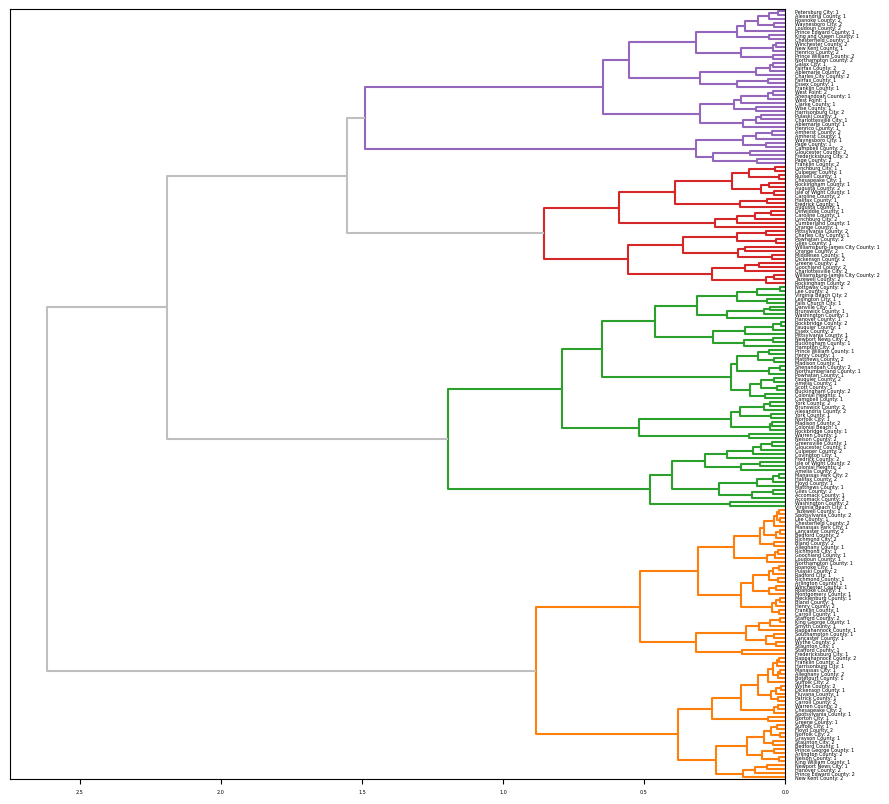

In [54]:
#Performing HCA
cluster_dict_pca = hca(X, linkage_method='ward', color_thresh=1.5, fignum=2, figname="HAC_TRANSCRIPTS_PCA")

In [55]:
#Extracting the data from a dictionary to prepare for merger back with TRANSCRIPT_LIB
pca_cluster = pd.DataFrame(columns=['pca_cluster', 'district_id', 'date_order'])

for cluster in range(1,len(cluster_dict_pca)+1):
    for district_id_date_order_pair in range(len(cluster_dict_pca[cluster])):
        temp_df = pd.DataFrame(columns=['pca_cluster', 'district_id', 'date_order'])
        new_data = [cluster, cluster_dict_pca[cluster][district_id_date_order_pair][0], cluster_dict_pca[cluster][district_id_date_order_pair][1]]
        new_row = pd.DataFrame([new_data], columns=['pca_cluster', 'district_id', 'date_order'])
        pca_cluster = pd.concat([pca_cluster, new_row], ignore_index=True)

pca_cluster = pca_cluster.set_index(['district_id','date_order'])

In [56]:
#Merging TRANSCRIPT_LIB with the dendrogram cluster
TRANSCRIPT_LIB = pd.merge(TRANSCRIPT_LIB, pca_cluster, left_index=True, right_index=True)

In [57]:
TRANSCRIPT_LIB['pca_cluster'].value_counts()

1    68
2    56
4    39
3    30
Name: pca_cluster, dtype: int64

### How many school districts have all district_id's in the same cluster?

In [58]:
counts = (TRANSCRIPT_LIB.groupby('district_id')['pca_cluster']
                    .nunique()
                    .value_counts()
                    .loc[1])

In [59]:
#73 districts have the same cluster 
counts

73

### Which school districts have district_id's that are in different clusters?

In [60]:
counts = TRANSCRIPT_LIB.groupby('district_id')['pca_cluster'].nunique()
not_unique_counts = counts[counts != 1]

In [61]:
not_unique_counts

district_id
16     2
19     2
21     2
24     2
26     2
28     2
31     2
33     2
34     2
35     2
36     2
37     2
39     2
41     2
42     2
44     2
46     2
52     2
53     2
62     2
63     2
65     2
71     2
72     2
73     2
75     2
77     2
80     2
85     2
92     2
93     2
101    2
104    2
110    2
113    2
117    2
118    2
132    2
135    2
136    2
144    2
Name: pca_cluster, dtype: int64

### How many school districts were formerly grouped together in the simple clustering approach and no longer grouped together using pca's?

In [62]:
TRANSCRIPT_LIB.loc[TRANSCRIPT_LIB['dendrogram_cluster'] == 3].groupby('pca_cluster').count()

source_file_path  transcript_date  district_name  \
pca_cluster                                                     
1                          13               13             13   
2                          44               44             44   
3                          30               30             30   
4                          23               23             23   

             transcript_title  label  dendrogram_cluster  
pca_cluster                                               
1                          13     13                  13  
2                          44     44                  44  
3                          30     30                  30  
4                          23     23                  23

In [63]:
TRANSCRIPT_LIB.loc[TRANSCRIPT_LIB['dendrogram_cluster'] == 2].groupby('pca_cluster').count()

source_file_path  transcript_date  district_name  \
pca_cluster                                                     
1                          19               19             19   
2                           6                6              6   
4                          13               13             13   

             transcript_title  label  dendrogram_cluster  
pca_cluster                                               
1                          19     19                  19  
2                           6      6                   6  
4                          13     13                  13

In [64]:
TRANSCRIPT_LIB.loc[TRANSCRIPT_LIB['dendrogram_cluster'] == 1].groupby('pca_cluster').count()

source_file_path  transcript_date  district_name  \
pca_cluster                                                     
1                          36               36             36   
2                           6                6              6   
4                           3                3              3   

             transcript_title  label  dendrogram_cluster  
pca_cluster                                               
1                          36     36                  36  
2                           6      6                   6  
4                           3      3                   3

Based on my interpretation, it appears that a substantial number of districts that were in the 3rd cluster for the simple HCA approach were grouped in the 2nd or 3rd cluster for the PCA approach. The remaining district-date pairs went to the 1st or 4th cluster pair. For the 2nd cluster for the simple HCA approach, the majority of districts went into the 1st or 4th cluster for the PCA approach with a few going into the 2nd cluster. Finally, for the 1st cluster for the simple HCA approach, the majority were grouped in the 1st cluster for the PCA approach with a few going into the 2nd and 4th cluster.

Although the groups become more nuanced when attempting to uncover the latent semantic structure, there is still some degree of evidence that certain school districts may be 'similar' in their content. The evidence from the 1st and 3rd simple HCA clusters converted into the PCA clusters suggest that the overarching content is relatively stable since a substantial number of district-date pairs went into a narrow set of clusters for each. The 2nd cluster in the simple HCA approach may be reflective of how much on the 'cusp' these various district-date pairs were.

### How might lexical differences illustrate how school board meetings are similar or different?

In [65]:
#Use index to get only PC features, so that the matrices align
TRANSCRIPT_DCM2 = districts_dates_max_tfidf_L2.dot(TRANSCRIPT_COMPS[TRANSCRIPT_COVARIANCE.index].T) 
TRANSCRIPT_DCM2 = TRANSCRIPT_DCM2.join(TRANSCRIPT_LIB['dendrogram_cluster'], on=['district_id','date_order'])

TRANSCRIPT_DCM3 = districts_dates_max_tfidf_L2.dot(TRANSCRIPT_COMPS[TRANSCRIPT_COVARIANCE.index].T) 
TRANSCRIPT_DCM3 = TRANSCRIPT_DCM2.join(TRANSCRIPT_LIB['pca_cluster'], on=['district_id','date_order'])

In [66]:
vis_loadings(0,1)

In [67]:
vis_pcs2(TRANSCRIPT_DCM2, 0, 1)

In [68]:
vis_pcs3(TRANSCRIPT_DCM3, 0, 1)

Although it is important to acknowledge that there is noise associated with analyzing at the district-date level because some individual speakers may focus on vastly different topics, there is some suggestive evidence that the lexical content may point toward why certain district-date pairs are clustered together. In particular, PC0 appears to focus on COVID-19, and PC1 appears to focus on "Identity Politics". 

From the original dendrogram clusters, the 1st cluster (green) appears to mostly focus on grouping district-date pairs that discuss COVID-19 with some conversations around Identity Politics. The 2nd cluster (red) appears to less frequently discuss Identity Politics but discusses COVID-19. The 3rd cluster (blue) also appears to discuss COVID-19 but with has a larger focus on Identity Politics.

For the PCA clusters, the 1st cluster (green) appears to focus on COVID-19 with some conversations around Identity Politics. The 2nd cluster (blue) appears to have a larger mix of both COVID-19 and Identity Politics. The 3rd cluster (purple) appears to less frequently discuss both Identity Politics and COVID-19. The 4th cluster appears to vary in the degree that COVID-19 and Identity Politics are discussed with a slight emphasis on Identity Politics.

In [69]:
vis_loadings(0,2)

In [70]:
vis_pcs2(TRANSCRIPT_DCM2, 0, 2)

In [71]:
vis_pcs3(TRANSCRIPT_DCM3, 0, 2)

Although it is important to acknowledge that there is noise associated with analyzing at the district-date level because some individual speakers may focus on vastly different topics, there is some suggestive evidence that the lexical content may point toward why certain district-date pairs are clustered together. In particular, PC0 appears to focus on COVID-19, and PC2 appears to focus on "School Operations / General Business" (i.e. teacher pay, staffing, transportation, etc.)

From the original dendrogram clusters, the 1st cluster (green) appears to mostly focus on grouping district-date pairs that discuss COVID-19 with some conversations around School Operations. The 2nd cluster (red) appears to less frequently discuss School Operations but discusses COVID-19. The 3rd cluster (blue) also appears to discuss COVID-19 but with has a larger focus on School Operations.

For the PCA clusters, the 1st cluster (green) appears to focus on COVID-19 with some conversations around School Operations. The 2nd cluster (blue) appears to have a larger mix of both COVID-19 but less variation across School Operations. The 3rd cluster (purple) appears to have no clear relationship between School Operations and COVID-19. The 4th cluster appears to vary in the degree that COVID-19 and Identity Politics are discussed with a slight emphasis on School Operations.

In [72]:
vis_loadings(1,2)

In [73]:
vis_pcs2(TRANSCRIPT_DCM2, 1, 2)

In [74]:
vis_pcs3(TRANSCRIPT_DCM3, 1, 2)

Although it is important to acknowledge that there is noise associated with analyzing at the district-date level because some individual speakers may focus on vastly different topics, there is some suggestive evidence that the lexical content may point toward why certain district-date pairs are clustered together. In particular, PC1 appears to focus on Identity Politics, and PC2 appears to focus on "School Operations / General Business" (i.e. teacher pay, staffing, transportation, etc.)

From the original dendrogram clusters, the 1st cluster (green) appears to mostly focus on grouping district-date pairs that discuss School Operations with some conversations around Identity Politics. The 2nd cluster (red) appears to more frequently discuss School Operations but discusses Identity Politics less. The 3rd cluster (blue) also appears to discuss Identity Politics but with has a larger focus on School Operations.

For the PCA clusters, the 1st cluster (green) appears to focus on School Operations a lot more than Identity Politics. The 2nd cluster (blue) appears to have a larger mix of Identity Politics but less variation across School Operations. The 3rd cluster (purple) appears to have no clear relationship between School Operations and Identity Politics. The 4th cluster appears to vary in the degree that School Operations and Identity Politics are discussed with a positive linear relationship between the two.

In Sum...

dendrogram

1st Cluster (Green): COVID-19 appears to be the focal point with some discussion around Identity Politics and School Operations.

2nd Cluster (Red): COVID-19 again appears to be the focal point, followed by School Operations. Identity Politics is less frequently discussed.

3rd Cluster (Blue): Focus on School Operations and Identity Politics with some discussion around COVID-19.

PCA

1st Cluster (Green): COVID-19 appears to be the focal point followed by conversations around School Operations. Identity Politics seem to be less relevant.

2nd Cluster (Blue): Both COVID-19 and Identity Politics appear to be the focal point with far less emphasis on School Operations.

3rd Cluster (Purple): This cluster does not appear to be well represented by COVID-19, Identity Politics, or School Operations.

4th Cluster (Red): Focuses on Identity Politics and School Operations but less so on COVID-19.

### Saving Files

In [75]:
TRANSCRIPT_DOC.to_csv(f"{table_home}/TRANSCRIPT_DOC.csv", index=True)
TRANSCRIPT_DCM.to_csv(f"{table_home}/TRANSCRIPT_DCM.csv", index=True)
TRANSCRIPT_COMPS.to_csv(f"{table_home}/TRANSCRIPT_COMPS.csv", index=True)
TRANSCRIPT_LOADINGS.to_csv(f"{table_home}/TRANSCRIPT_LOADINGS.csv", index=True)

# Rather than simply examine lexical differences, what are the topics covered by school board meetings and the words associated with those topics?

Although PCA helps expose the lexical differences that cluster documents in a particular way, the transcripts likely feature a mixture of topics since each individual speaker opts to speak on a topic of most interest. TF-IDF poses a limitation, and Latent Dirichlet Allocation leverages a probabilistic model to estimate the probability distribution for topics in documents and words in topics. 

In essence, we hope to surface the stories underlying the school board meetings leading up to Governor Youngkin's election.

To accomplish this task, we need the following things accomplished:

1) Filter for Nouns

2) Create Vector Space 

3) Generate Models to create Theta and Phi Tables

4) Create / Label Topics

5) Identifying how similar the topics are (Topic Similarity)

6) Identifying co-occurence of the topics (Topic Contiguity)

### Filter for Nouns

In [76]:
TRANSCRIPT_DOCS_DISTRICTS_DATE = TRANSCRIPT_CORPUS[TRANSCRIPT_CORPUS.pos.str.match(r'^NNS?$')]\
    .groupby(['district_id', 'date_order']).term_str\
    .apply(lambda x: ' '.join(x))\
    .to_frame()\
    .rename(columns={'term_str':'doc_str'})

In [77]:
TRANSCRIPT_DOCS_DISTRICTS_DATE

doc_str
district_id date_order                                                   
1           1           profanity nature remarks speakers subject comm...
            2           rules rules speaking rules comment name addres...
2           1           page members school board school leadership te...
            2           members board name hater year law student comm...
3           1           statement ladies gentlemen board meeting paren...
...                                                                   ...
144         1           morning time minutes school board administrati...
            2           kidding guys board change education teachers a...
202         1           board community member state school loss staff...
207         1           community members delegations model policy tra...
            2           calendar changes diversity awareness recogniti...

[193 rows x 1 columns]

### Create Vector Space

In [78]:
#convert our F1 corpus of district-dates into a document-term vector space of word counts.
count_engine = CountVectorizer(max_features=4000, stop_words='english')
count_model_districts_date = count_engine.fit_transform(TRANSCRIPT_DOCS_DISTRICTS_DATE.doc_str)
TERMS_DISTRICTS_DATE = count_engine.get_feature_names_out()

In [79]:
#Vocab Set-up
VOCAB_DISTRICTS_DATE = pd.DataFrame(index=TERMS_DISTRICTS_DATE)
VOCAB_DISTRICTS_DATE.index.name = 'term_str'

In [80]:
#DTM Set-Up
DTM_DISTRICTS_DATE = pd.DataFrame(count_model_districts_date.toarray(), index=TRANSCRIPT_DOCS_DISTRICTS_DATE.index, columns=TERMS_DISTRICTS_DATE)
VOCAB_DISTRICTS_DATE['doc_count'] = DTM_DISTRICTS_DATE.astype('bool').astype('int').sum()
TRANSCRIPT_DOCS_DISTRICTS_DATE['term_count'] = DTM_DISTRICTS_DATE.sum(1)

In [81]:
VOCAB_DISTRICTS_DATE

doc_count
term_str            
abilities          8
ability           47
abortion           8
absence           10
absences           6
...              ...
youth             20
zero              14
zone               5
zones              3
zoom              10

[4000 rows x 1 columns]

In [82]:
TRANSCRIPT_DOCS_DISTRICTS_DATE

doc_str  \
district_id date_order                                                      
1           1           profanity nature remarks speakers subject comm...   
            2           rules rules speaking rules comment name addres...   
2           1           page members school board school leadership te...   
            2           members board name hater year law student comm...   
3           1           statement ladies gentlemen board meeting paren...   
...                                                                   ...   
144         1           morning time minutes school board administrati...   
            2           kidding guys board change education teachers a...   
202         1           board community member state school loss staff...   
207         1           community members delegations model policy tra...   
            2           calendar changes diversity awareness recogniti...   

                        term_count  
district_id date_order              
1           1                  887  
            2                  608  
2           1                  243  
            2                  495  
3           1                   71  
...                            ...  
144         1                  320  
            2                  298  
202         1                   10  
207         1                    7  
            2                   14  

[193 rows x 2 columns]

### Generate Models

In [83]:
lda_engine = LDA(n_components=10, max_iter=50, learning_offset=50., random_state=0)

In [84]:
TNAMES = [f"T{str(x).zfill(len(str(10)))}" for x in range(10)]

In [85]:
lda_model_districts_date = lda_engine.fit_transform(count_model_districts_date)

In [86]:
#Theta Generation
THETA_DISTRICTS_DATE = pd.DataFrame(lda_model_districts_date, index=TRANSCRIPT_DOCS_DISTRICTS_DATE.index)
THETA_DISTRICTS_DATE.columns.name = 'topic_id'
THETA_DISTRICTS_DATE.columns = TNAMES

In [87]:
THETA_DISTRICTS_DATE

T00       T01       T02       T03       T04  \
district_id date_order                                                     
1           1           0.949554  0.000113  0.000113  0.000113  0.000113   
            2           0.579111  0.000164  0.396020  0.000164  0.000164   
2           1           0.655275  0.000410  0.000410  0.341446  0.000410   
            2           0.998185  0.000202  0.000202  0.000202  0.000202   
3           1           0.389106  0.001389  0.001389  0.523119  0.001389   
...                          ...       ...       ...       ...       ...   
144         1           0.341000  0.345869  0.000312  0.310950  0.000312   
            2           0.221588  0.775735  0.000335  0.000335  0.000334   
202         1           0.009093  0.374195  0.553063  0.009093  0.009093   
207         1           0.458689  0.012502  0.012504  0.012503  0.012504   
            2           0.006668  0.006670  0.006668  0.006668  0.939985   

                             T05       T06       T07       T08       T09  
district_id date_order                                                    
1           1           0.000113  0.000113  0.049545  0.000113  0.000113  
            2           0.000164  0.000164  0.000164  0.023718  0.000164  
2           1           0.000410  0.000410  0.000410  0.000410  0.000410  
            2           0.000202  0.000202  0.000202  0.000202  0.000202  
3           1           0.001389  0.001389  0.001389  0.078051  0.001389  
...                          ...       ...       ...       ...       ...  
144         1           0.000312  0.000312  0.000312  0.000312  0.000312  
            2           0.000334  0.000335  0.000335  0.000335  0.000335  
202         1           0.009091  0.009093  0.009093  0.009094  0.009093  
207         1           0.012500  0.012504  0.012502  0.012503  0.441289  
            2           0.006667  0.006669  0.006668  0.006668  0.006668  

[193 rows x 10 columns]

In [88]:
#Phi Generation
PHI_DISTRICTS_DATE = pd.DataFrame(lda_engine.components_, columns=TERMS_DISTRICTS_DATE, index=TNAMES)
PHI_DISTRICTS_DATE.index.name = 'topic_id'
PHI_DISTRICTS_DATE.columns.name  = 'term_str'

In [89]:
PHI_DISTRICTS_DATE

term_str  abilities    ability  abortion    absence  absences    absent  \
topic_id                                                                  
T00        5.891968  27.639007  2.999673   0.100020  0.100010  0.100036   
T01        0.100004  11.904419  0.100010   0.100076  9.099961  1.886505   
T02        0.100017   2.092271  3.972046   2.414336  0.100000  0.100000   
T03        3.307939  23.473030  1.328218  11.782266  0.100007  2.313459   
T04        0.100000   3.098060  0.100000   0.100000  0.100000  0.100000   
T05        0.100000   0.100000  0.100000   0.100000  0.100000  0.100000   
T06        0.100026   2.238640  0.100004   0.100000  0.100000  0.100000   
T07        0.100028   1.152336  0.100000   0.100000  0.100022  0.100000   
T08        0.100000   4.885045  0.100020   4.103301  0.100000  0.100000   
T09        0.100017   7.417192  0.100028   0.100000  0.100000  0.100000   

term_str  absenteeism  absolute  abundance      abuse  ...       years  \
topic_id                                               ...               
T00          2.099652  0.100024   0.100012   8.635441  ...  219.858924   
T01          0.100052  0.100057   0.100013   0.100026  ...   33.205715   
T02          0.100018  0.100011   0.100020   7.161722  ...   33.841706   
T03          0.100000  3.099853   1.227551  17.437473  ...   96.235103   
T04          0.100273  0.100000   0.100000   0.100000  ...    3.489702   
T05          0.100000  0.100000   0.100000   0.100000  ...    1.099980   
T06          0.100030  0.100015   0.100000   0.100007  ...   20.578216   
T07          0.100000  0.100038   1.972402   1.280918  ...   43.684553   
T08          1.100000  0.100000   0.100002   1.110898  ...   34.917910   
T09          1.099974  0.100002   0.100000   7.973515  ...   35.088189   

term_str    yellow       yes  yesterday      yoga      youth      zero  \
topic_id                                                                 
T00       0.100025  0.100026  29.307467  0.100008  20.364538  5.436085   
T01       0.100000  0.100014   0.100030  0.100000   0.100014  0.100036   
T02       0.100000  1.100000   1.155338  0.100003   0.100005  0.100000   
T03       0.100013  5.552818   5.837082  4.099983   6.876144  7.476301   
T04       0.100000  0.100000   0.100017  0.100000   0.100000  0.100000   
T05       0.100000  0.100000   0.100000  0.100000   0.100000  0.100000   
T06       1.099992  0.100000   0.100018  0.100000   0.100058  0.100004   
T07       2.099969  2.505692   0.100000  0.100000   0.100008  1.387566   
T08       0.100000  2.241448   0.100019  1.100000   0.100001  0.100008   
T09       0.100000  0.100002   0.100029  0.100005   7.059232  0.100000   

term_str      zone     zones      zoom  
topic_id                                
T00       2.094579  0.100065  6.164902  
T01       0.100026  0.100000  0.100135  
T02       0.100023  0.100003  0.100000  
T03       1.763260  3.099978  0.100017  
T04       0.100000  0.100000  0.100000  
T05       0.100000  0.100000  0.100000  
T06       0.100000  0.100000  0.100000  
T07       2.442106  0.100000  3.322327  
T08       0.100003  1.099950  1.812618  
T09       0.100004  0.100005  1.100001  

[10 rows x 4000 columns]

### Create Topics

In [90]:
#Creating Topics
TOPICS_DISTRICTS_DATE = PHI_DISTRICTS_DATE.stack().to_frame('topic_weight').groupby('topic_id')\
    .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(40).reset_index().drop('topic_id', axis=1)['term_str'])

TOPICS_DISTRICTS_DATE['label'] = TOPICS_DISTRICTS_DATE.apply(lambda x: x.name + ' ' + ', '.join(x[:40]), 1)

In [91]:
#Sorting Documents by Topic Weight
TOPICS_DISTRICTS_DATE['doc_weight_sum'] = THETA_DISTRICTS_DATE.sum()
TOPICS_DISTRICTS_DATE['term_freq'] = PHI_DISTRICTS_DATE.sum(1) / PHI_DISTRICTS_DATE.sum(1).sum()

In [92]:
TOPICS_DISTRICTS_DATE

term_str         0         1         2        3          4            5  \
topic_id                                                                  
T00         school  students  children     kids       time        board   
T01       students      time  teachers   school        day        staff   
T02          board    school  children  parents     people       county   
T03         school  children     board   people   students      parents   
T04          board    school   meeting   people       time      schools   
T05         slaves   actions   history   people  intention  convictions   
T06          board    school      time     race     equity      schools   
T07         school     board      time      bus     people      drivers   
T08         school      time      city    board   students          day   
T09         school  students     books    board     people         time   

term_str         6          7           8           9  ...            33  \
topic_id                                               ...                 
T00        parents   teachers        year     schools  ...         masks   
T01           year    teacher        days   educators  ...    colleagues   
T02           time  community    district     members  ...         thing   
T03           time       mask     schools        kids  ...         right   
T04       students       city    teachers     evening  ...        member   
T05        article    decades  conscience  courthouse  ...  circumstance   
T06       students     policy      people    children  ...          kids   
T07       students    schools    children       years  ...       evening   
T08         people     podium       state         bus  ...     educators   
T09        speaker    student        year   community  ...      lacrosse   

term_str              34           35         36          37        38  \
topic_id                                                                 
T00                  bus         room    members    comments      days   
T01               things          job     change  conditions      week   
T02       responsibility       theory      right       thank  campbell   
T03               policy   government    country      choice     years   
T04               public         work      thing   everybody   remarks   
T05                track  delegations       pope       spoke  deadline   
T06                  law       member  diversity     student      word   
T07            committee       county     patron     anybody      hour   
T08              minutes    employees    teacher         job  citizens   
T09              reading    questions        way       staff     grade   

term_str           39                                              label  \
topic_id                                                                   
T00       information  T00 school, students, children, kids, time, bo...   
T01               pay  T01 students, time, teachers, school, day, sta...   
T02          comments  T02 board, school, children, parents, people, ...   
T03             thing  T03 school, children, board, people, students,...   
T04              data  T04 board, school, meeting, people, time, scho...   
T05            cohort  T05 slaves, actions, history, people, intentio...   
T06             money  T06 board, school, time, race, equity, schools...   
T07          comments  T07 school, board, time, bus, people, drivers,...   
T08         community  T08 school, time, city, board, students, day, ...   
T09              kind  T09 school, students, books, board, people, ti...   

term_str doc_weight_sum term_freq  
topic_id                           
T00           65.621568  0.370984  
T01           15.847723  0.059039  
T02           12.113440  0.066868  
T03           39.262299  0.254170  
T04           10.626136  0.014138  
T05            1.412746  0.003917  
T06           11.533694  0.066543  
T07           19.416444  0.040407  
T08            9.478613 

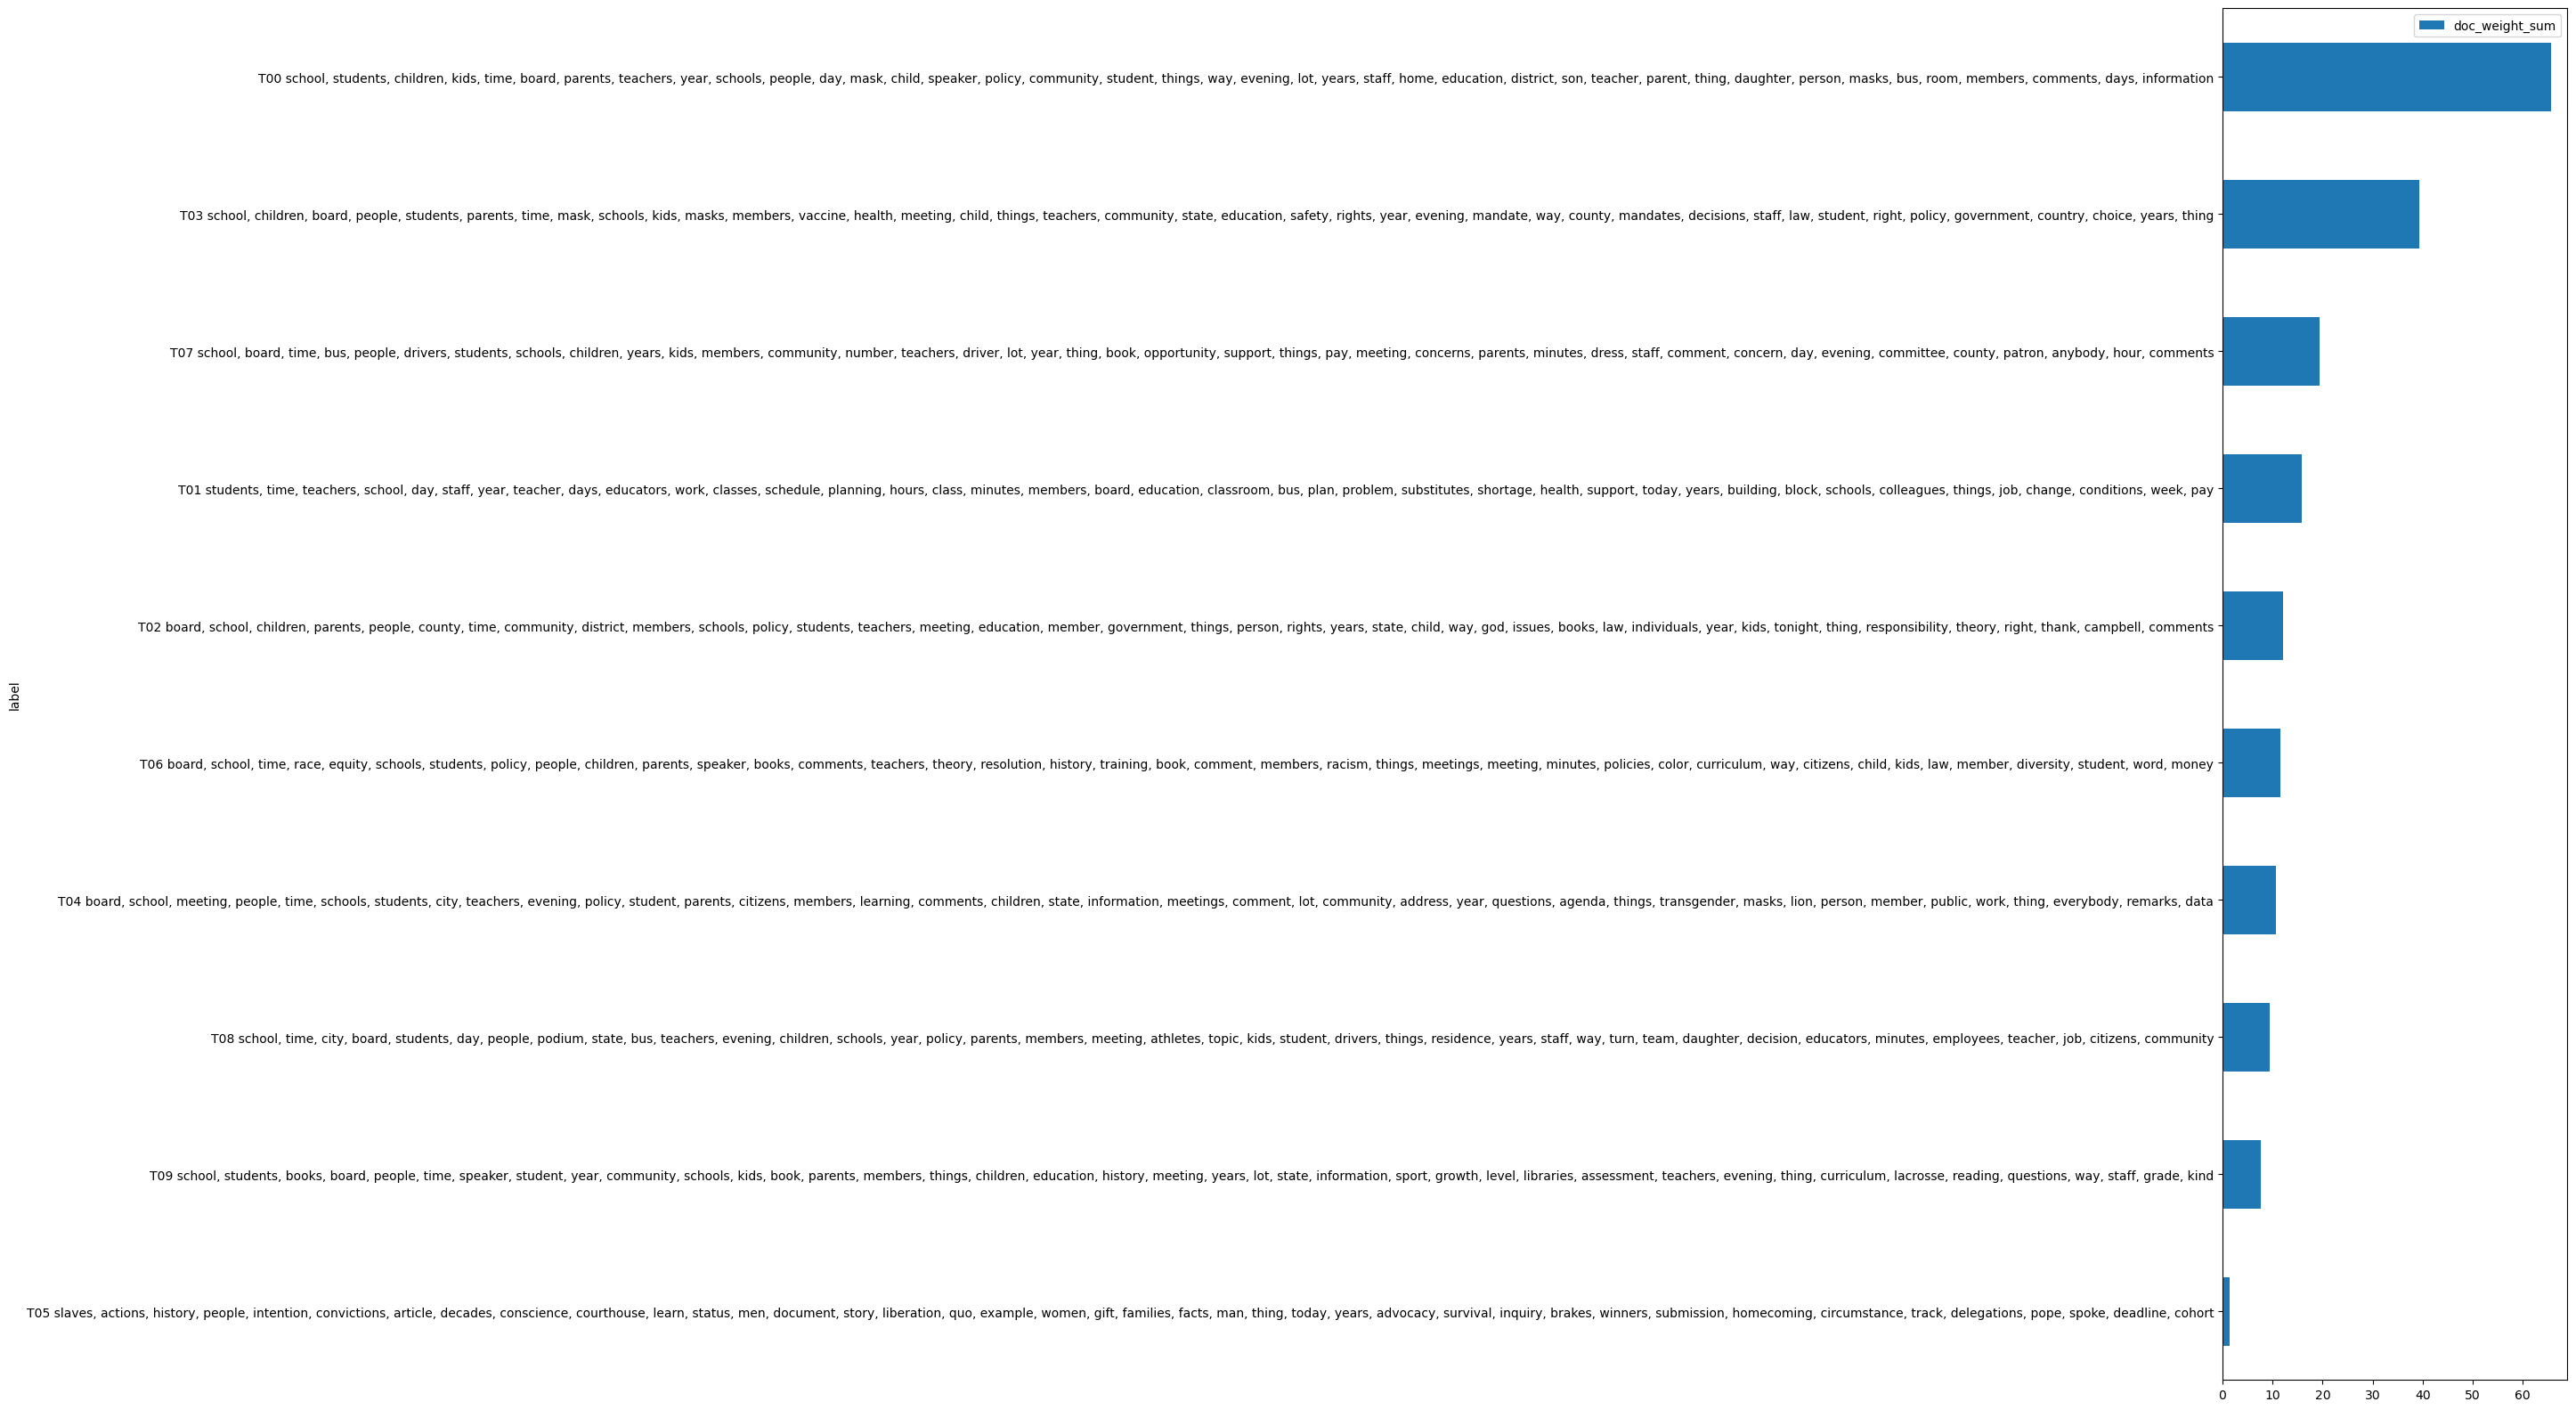

In [93]:
TOPICS_DISTRICTS_DATE.sort_values('doc_weight_sum', ascending=True).plot.barh(y='doc_weight_sum', x='label', figsize=(5, 40/2));

### Topic Similarity

In [94]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist #, squareform
# from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt            

class HAC:
    """This class takes an arbitrary vector space and represents it 
    as a hierarhical agglomerative cluster tree. The number of observations
    should be sufficiently small to allow being plotted."""

    w:int = 10
    labelsize:int = 14
    orientation:str = 'left'
    sim_metric:str = 'cosine' # The distance metric to use. The distance function can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulsinski’, ‘kulczynski1’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘yule’.
    tree_method:str = 'ward'
    norm:str = 'l2' # l1, l2, max
    
    def __init__(self, M, labels=None):
        self.M = M
        self.h = M.shape[0]
        if labels:
            self.labels = labels            
        else:
            self.labels = M.index.tolist()

    def get_sims(self):
        self.SIMS = pdist(normalize(self.M, norm=self.norm), metric=self.sim_metric)

    def get_tree(self):
        self.TREE = sch.linkage(self.SIMS, method=self.tree_method)        
        
    def plot_tree(self):
        plt.figure()
        fig, axes = plt.subplots(figsize=(self.w, self.h / 3))
        dendrogram = sch.dendrogram(self.TREE, labels=self.labels, orientation=self.orientation);
        plt.tick_params(axis='both', which='major', labelsize=self.labelsize)
        
    def plot(self):
        self.get_sims()
        self.get_tree()
        self.plot_tree()

In [95]:
labels = [f"{TOPICS_DISTRICTS_DATE.label}"]
labels = pd.Series(labels[0].split('\n')[1:-1]).str.split().apply(lambda x: ' '.join(x[1:]))

<Figure size 640x480 with 0 Axes>

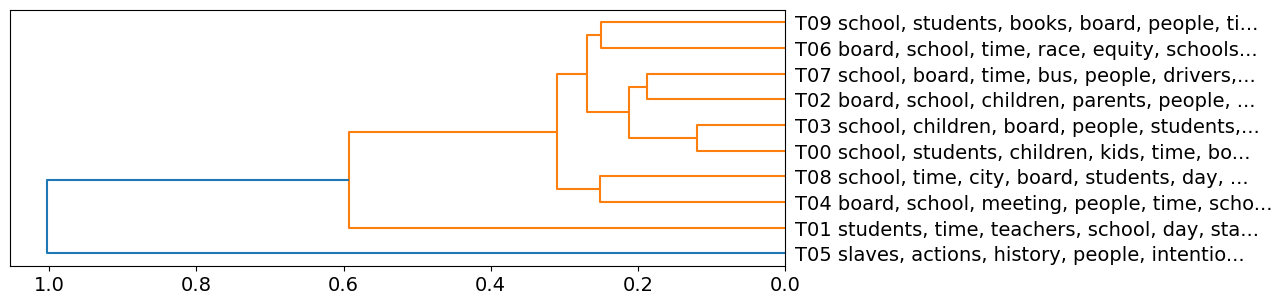

In [96]:
HAC(PHI_DISTRICTS_DATE, labels=labels.tolist()).plot();

<Figure size 640x480 with 0 Axes>

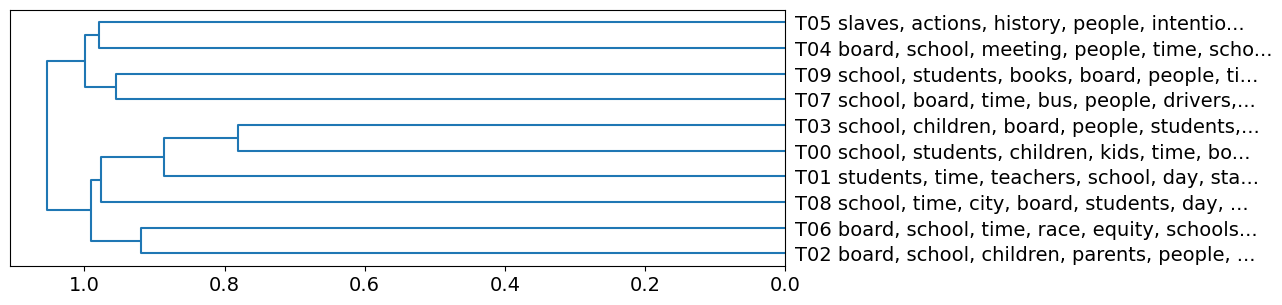

In [97]:
HAC(THETA_DISTRICTS_DATE.T, labels=labels.tolist()).plot();

### Topic Contiguity

In [98]:
X = pd.concat([THETA_DISTRICTS_DATE.corr(method='kendall').stack().to_frame('corr_theta'), 
               PHI_DISTRICTS_DATE.T.corr(method='kendall').stack().to_frame('corr_phi')], axis=1)
X.index.names = ['topic_id_x','topic_id_y']
X = X.query("topic_id_x < topic_id_y") 
X['corr_mean'] = (X.corr_theta + X.corr_phi) / 2

In [99]:
X = X.reset_index()
X['label_x'] = X.topic_id_x.map(TOPICS_DISTRICTS_DATE.label)
X['label_y'] = X.topic_id_y.map(TOPICS_DISTRICTS_DATE.label)
X = X.set_index(['topic_id_x','topic_id_y'])

In [100]:
px.scatter(X, 'corr_phi', 'corr_theta', hover_data=['label_x', 'label_y'], width=600, height=1000)

In [101]:
X.sort_values('corr_phi', ascending=False)[['corr_phi', 'label_x','label_y']]\
    .head(20).style.background_gradient(cmap=colors)

In [102]:
X.sort_values('corr_phi', ascending=True)[['corr_phi', 'label_x','label_y']]\
    .head(20).style.background_gradient(cmap=colors)

In [103]:
X.sort_values('corr_theta', ascending=False)[['corr_theta', 'label_x','label_y']]\
    .head(20).style.background_gradient(cmap=colors)

In [104]:
X.sort_values('corr_theta', ascending=True)[['corr_theta', 'label_x','label_y']]\
    .head(20).style.background_gradient(cmap=colors)

# What are the topics covered in School Board Meetings? How much are those topics prioritized?


T00: [General School Topics] - Priority 1

T01: [School Staffing Problems] - Priority 4

T02: [Community Member Rights] - Priority 5

T03: [Mask Mandates] - Priority 2

T04: [LGBTQ+ Issues] - Priority 7

T05: [History / Invoking Founding of U.S.] - Priority 10

T06: ["Critical Race Theory"] - Priority 6

T07: [School Operations] - Priority 3

T08: [School Extracurriculars?] - Priority 8

T09: [Assessments and Performance] - Priority 9

### What topics appear to be closely related via Topic Similarity?

Topic Words: T9/T6; [T7/T2 + T3/T0]; T8/T4;

Document Words: [T5/T4 + T9/T7]; [T3/T0 + T1 + T8]; T6/T2

### What topics appear to be closely related via Topic Contiguity?

In [105]:
#Setting up data to create a heatmap
X2 = X.reset_index()
df_pivot = X2.pivot(index='topic_id_x', columns='topic_id_y', values='corr_phi')

<AxesSubplot:xlabel='topic_id_y', ylabel='topic_id_x'>

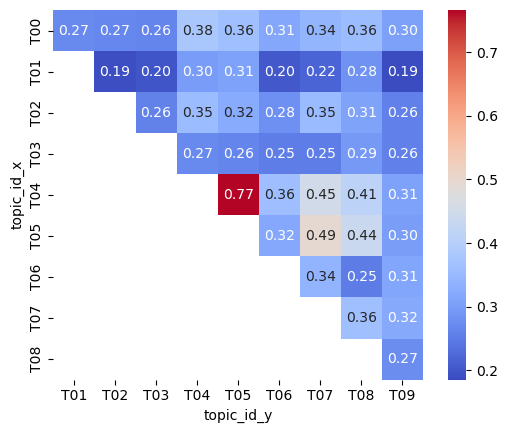

In [106]:
sns.heatmap(df_pivot, cmap='coolwarm', annot=True, fmt='.2f', square=True)

In [107]:
#Setting up data to create a heatmap
X3 = X.reset_index()
df_pivot2 = X3.pivot(index='topic_id_x', columns='topic_id_y', values='corr_theta')

<AxesSubplot:xlabel='topic_id_y', ylabel='topic_id_x'>

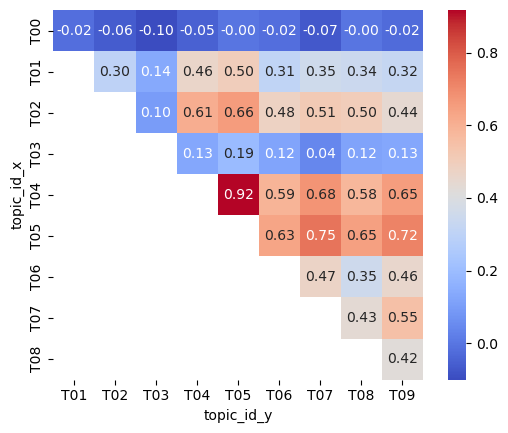

In [108]:
sns.heatmap(df_pivot2, cmap='coolwarm', annot=True, fmt='.2f', square=True)

Similar Phi (correlation > 0.4): Topic words related to LGBTQ+ Issues, History, School Operations, and School Extracurriculars seem to be somewhat related. [T4/T5, T5/T7, T4/T7, T5/T8, T4/T8]. It seems that T4/T5 are the most closely connected with LGBTQ+ Issues and History but most other topics are more loosely connected.

Dissimilar Phi (correlation < 0.2): Topic words related to General School Topics, School Staffing Problems, Community Member Rights, and Mask Mandates appear to be much less related [T1/T9, T1/T2, T1/T3]. It seems that T0, T1, T2, T3, T6, T7, T8, and T9 all have more distinctive topic words. 

Similar Theta (correlation > 0.7): Document words related to LGBTQ+ Issues, History, School Operations, and Assessments and Performance seem to be somewhat related. [T4/T5, T5/T7, T5/T9]. It appears that T2, T4, and T5 have substantial co-occurences with the topics that follow them (e.g., T4, T5, ..., T9).

Dissimilar Theta (correlation < -0.05): Document words related to General School Topics, Mask Mandates, School Operations, and Community Member Rights appear to be much less related [T0/T3, T0/T7, T0/T2]. It seems that T0, T3, and to an extent T1, have much lower correlations with other topics in a document. 

Overall, it seems to me that there are potentially overarching themes that appear across topic words and documents. In particular, the topic words that are most closely connected are those relating to LGBTQ+ Issues and History (of U.S.). It may be possible that T4's relationship with T7 and T8 may be attributable to aspects like "books" and "dress" and "athletes": this would be aligned with conversations around so-called 'pedophelia' in school books as well as controversies around the 'perverted' nature of dressing as a gender not assigned at birth or participating in athletics. The connection between T5 and these topics may be the weaponization of the founding father's "intention" against any policies or actions that are against the status quo (i.e., 'men' participating in women's sports is not what the founding fathers would have wanted).

The themes around documents seem to be the close connection between Topic 2 - Community Member Rights - and T4 to T9. It appears that community members (particularly parents) may believe that they have the right to impose their views on a range of topics such as LGBTQ+ Issues, Critical Race Theory, School Operations, School Extracurriculars, as well as Assessments and Performance. They may opt to invoke the Founding Fathers to claim their rights. The documents that focus on LGBTQ+ Issues and Invoking the Founding of the U.S. all seem to co-occur with Critical Race Theory, School Operations, School Extracurriculars, as well as Assessments and Performance. This may be indicative of all of the points of contention that are intricately connected.

### What are the primary (3) topics for each school district?

In [109]:
#Extracting out the school district names and bringing the school district names into the topics table.
TRANSCRIPT_LIB['label2'] = TRANSCRIPT_LIB.label.str.split(': ').str[0].str.lower()
label2 = sorted(TRANSCRIPT_LIB.label2.value_counts().index.to_list())
TOPICS_DISTRICTS_DATE[label2] = THETA_DISTRICTS_DATE.join(TRANSCRIPT_LIB, on=['district_id', 'date_order']).groupby('label2')[TNAMES].mean().T

C:\Users\johnw\AppData\Local\Temp\ipykernel_19280\3417495709.py:4: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\johnw\AppData\Local\Temp\ipykernel_19280\3417495709.py:4: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\johnw\AppData\Local\Temp\ipykernel_19280\3417495709.py:4: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

In [110]:
#Identifying the top 3 topics for each school district
top_topics = {}
for column in TOPICS_DISTRICTS_DATE.columns[43:]:
    top_topics[column] = TOPICS_DISTRICTS_DATE[column].sort_values(ascending=False).head(3).index.tolist()

In [111]:
#Identifying the values associated with the top 3 topics for each school district
top_topic_values = {}
for column in top_topics:
    top_topic_values[column] = []
    for topic in top_topics[column]:
        top_topic_values[column].append(TOPICS_DISTRICTS_DATE.loc[topic, column])
top_topic_values_df = pd.DataFrame.from_dict(top_topic_values)

In [112]:
#Reshaping the dataframe to fit an ideal structure: District | Top Topic 1 | Top Topic 1 Value | ... | Top Topic 3 | Top Topic 3 Value
top_topics_df = pd.DataFrame.from_dict(top_topics, orient='index', columns=['top_topic_1', 'top_topic_2', 'top_topic_3'])
top_topic_values_df = pd.DataFrame.from_dict(top_topic_values, orient='index', columns=['top_topic_1_value', 'top_topic_2_value', 'top_topic_3_value'])

merged_df = pd.concat([top_topics_df, top_topic_values_df], axis=1).reset_index()
merged_df.columns = ['district'] + merged_df.columns[1:].tolist()

top_three_topics = pd.melt(merged_df, id_vars=['district'], value_vars=['top_topic_1', 'top_topic_1_value', 'top_topic_2', 'top_topic_2_value', 'top_topic_3', 'top_topic_3_value'], var_name='topic_type', value_name='value')

top_three_topics = top_three_topics.pivot(index='district', columns='topic_type', values='value').reset_index()

In [113]:
#merging in the district_id's to top_three_topics by taking the TRANSCRIPT_LIB and creating a district column
TRANSCRIPT_LIB['district'] = TRANSCRIPT_LIB['district_name'].str.lower()
TRANSCRIPT_LIB2 = TRANSCRIPT_LIB.reset_index()
top_three_topics = top_three_topics.merge(TRANSCRIPT_LIB2[['district', 'district_id']], on='district', how='left')
top_three_topics = top_three_topics.set_index('district_id')
top_three_topics = top_three_topics.drop_duplicates()

In [114]:
top_three_topics

district top_topic_1 top_topic_1_value  \
district_id                                                                 
2                          ablemarle county         T00           0.82673   
1                           accomack county         T00          0.764333   
101                       alexandria county         T07          0.498496   
3                          alleghany county         T08          0.521713   
4                             amelia county         T08          0.497706   
...                                     ...         ...               ...   
131          williamsburg-james city county         T00          0.433036   
132                       winchester county         T08          0.553698   
96                              wise county         T03          0.899991   
97                             wythe county         T06          0.391593   
98                              york county         T00          0.433766   

            top_topic_2 top_topic_2_value top_topic_3 top_topic_3_value  
district_id                                                              
2                   T03          0.170824         T01          0.000306  
1                   T02          0.198067         T07          0.024855  
101                 T00          0.290195         T03          0.170721  
3                   T03          0.263484         T00          0.196477  
4                   T07          0.299101         T01           0.19407  
...                 ...               ...         ...               ...  
131                 T06          0.341447         T03          0.224518  
132                 T03           0.44305         T02          0.000407  
96                  T08          0.011113         T00          0.011113  
97                  T03          0.229557         T00          0.148365  
98                  T03          0.314884         T01          0.128654  

[113 rows x 7 columns]

### For each topic, how many school districts have that as their "top topic(s)"? 

In [115]:
top_topic_1_counts = top_topics_df['top_topic_1'].value_counts()

In [116]:
top_topic_1_counts

T00    42
T03    21
T07    12
T02     8
T01     8
T06     7
T04     6
T08     5
T09     3
T05     1
Name: top_topic_1, dtype: int64

In [117]:
top_topic_2_counts = top_topics_df['top_topic_2'].value_counts()

In [118]:
top_topic_2_counts

T03    30
T00    27
T01    13
T07    11
T09     8
T08     8
T06     7
T02     5
T04     4
Name: top_topic_2, dtype: int64

In [119]:
top_topic_3_counts = top_topics_df['top_topic_3'].value_counts()

In [120]:
top_topic_3_counts

T01    25
T00    21
T03    16
T06    12
T07    10
T09     9
T02     9
T04     6
T08     5
Name: top_topic_3, dtype: int64

It appears that the primary topic focused on has been General School Topics across school district's top 3 topics. In addition, Mask Mandates along with School Staffing Problems has consistently been a focal topic across school districts. While there has been some discussion of LGBTQ+ Issues, Critical Race Theory, and School Operations, those topics do not appear to be super salient for what individual speakers prioritize.

### What is the distribution of values for each topic across school districts? Is there a reasonable threshold to cut-off each topic?

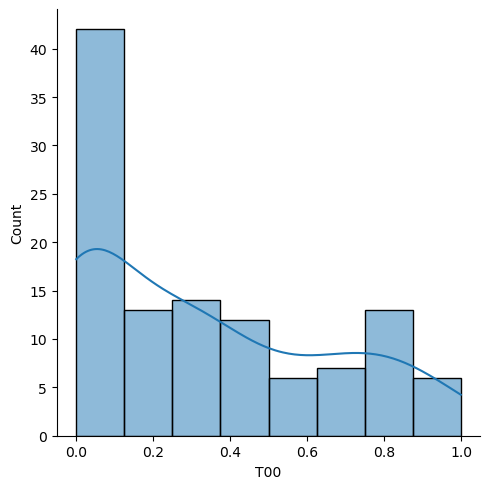

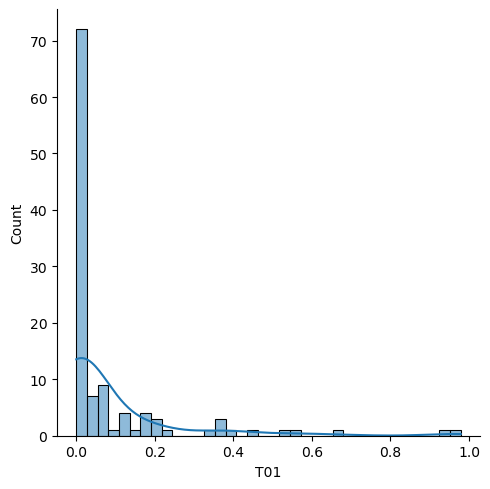

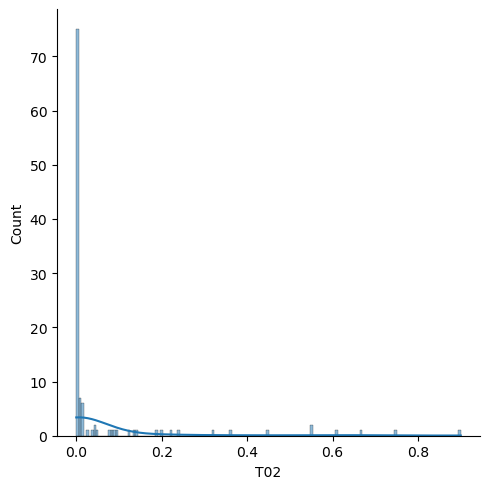

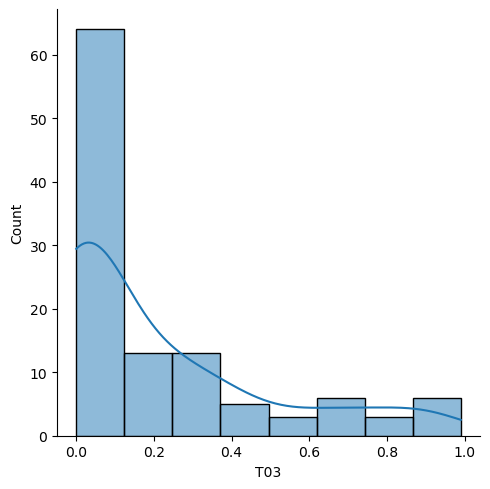

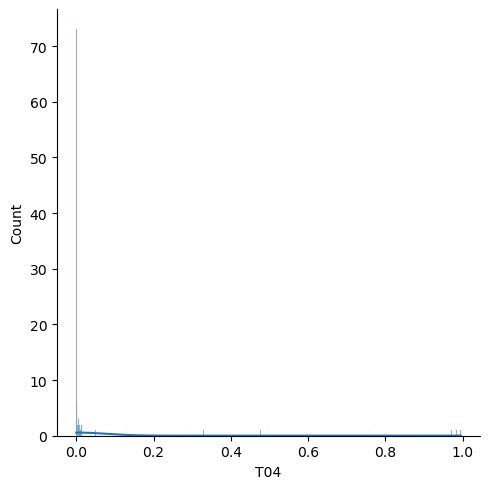

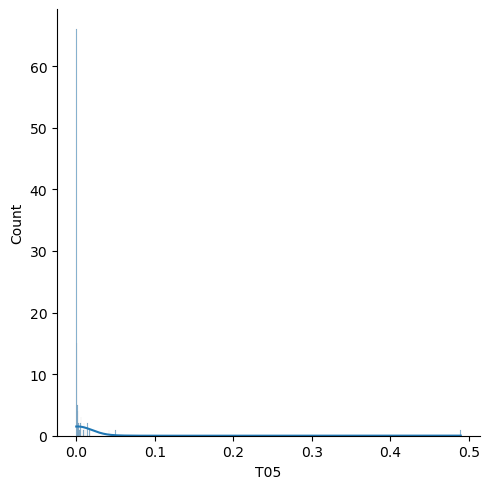

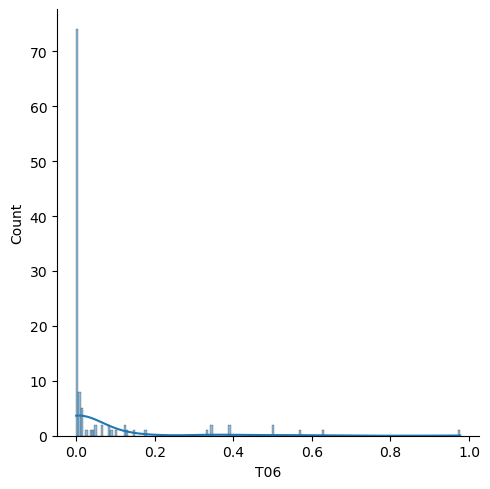

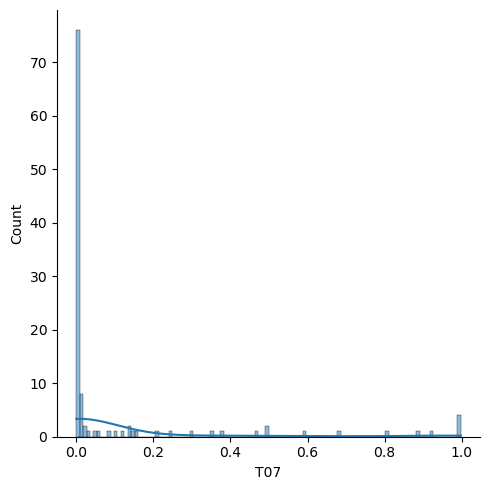

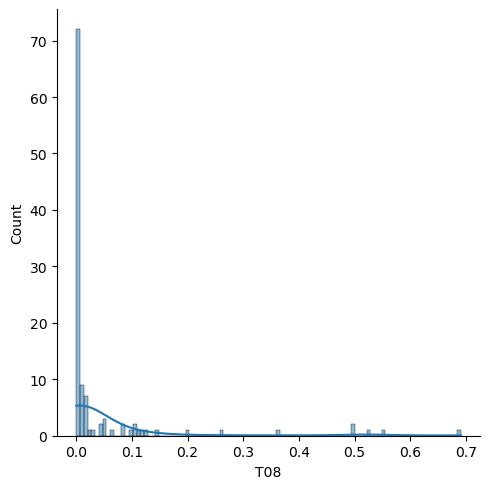

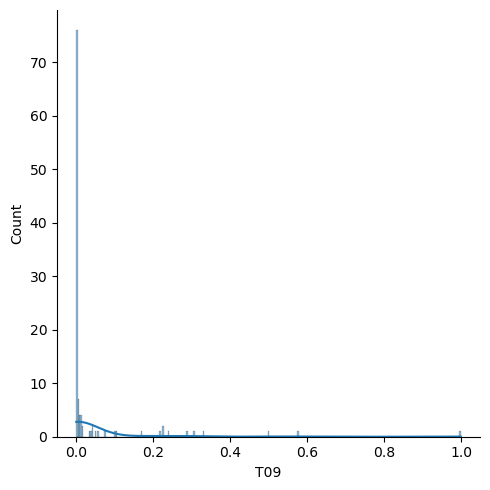

In [121]:
# Filter the columns to those that are school districts
cols = TOPICS_DISTRICTS_DATE.columns[43:]

# Loop through each row in the dataframe and plot the distribution of values for each column
for index, row in TOPICS_DISTRICTS_DATE.iterrows():
    sns.displot(row[cols], kde=True)

In [122]:
TOPICS_DISTRICTS_DATE.iloc[:, 43:].sum(axis=0)

term_str
ablemarle county                  1.0
accomack county                   1.0
alexandria county                 1.0
alleghany county                  1.0
amelia county                     1.0
                                 ... 
williamsburg-james city county    1.0
winchester county                 1.0
wise county                       1.0
wythe county                      1.0
york county                       1.0
Length: 113, dtype: float64

It appears that a lot of the distribution of values across topics are right skewed. Most school districts do not cover the majority of topics. There does appear to be a few school districts that cover each topic. After moving beyond values of 0.1, it appears that these school districts more concretely discuss a particular topic area, but it may not be a focal topic of the school district. Therefore I would want to identify a topic mixture that prioritizes certain topics.

### What is the distribution of values for each of the top topics?

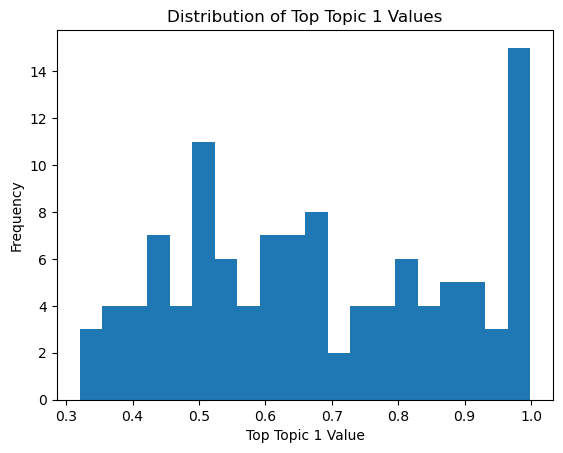

In [123]:
# create histogram
plt.hist(top_three_topics['top_topic_1_value'], bins=20)

# set axis labels and title
plt.xlabel('Top Topic 1 Value')
plt.ylabel('Frequency')
plt.title('Distribution of Top Topic 1 Values')

# display plot
plt.show()

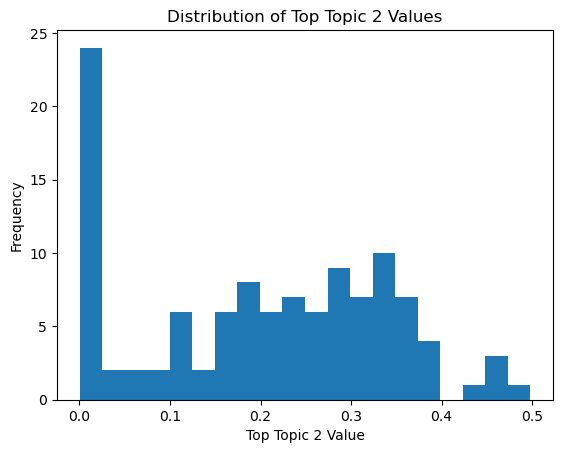

In [124]:
# create histogram
plt.hist(top_three_topics['top_topic_2_value'], bins=20)

# set axis labels and title
plt.xlabel('Top Topic 2 Value')
plt.ylabel('Frequency')
plt.title('Distribution of Top Topic 2 Values')

# display plot
plt.show()

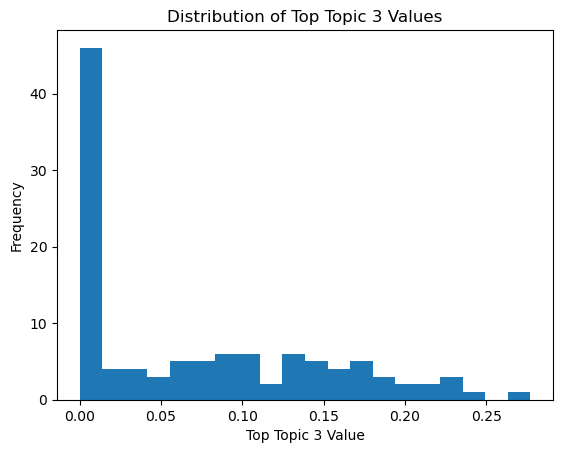

In [125]:
# create histogram
plt.hist(top_three_topics['top_topic_3_value'], bins=20)

# set axis labels and title
plt.xlabel('Top Topic 3 Value')
plt.ylabel('Frequency')
plt.title('Distribution of Top Topic 3 Values')

# display plot
plt.show()

### How many school districts have any of their top 3 topics exceed 0.30?

In [126]:
top_topic_counts_greater_3 = {}

for i in range(1, 4):
    mask = top_three_topics[f'top_topic_{i}_value'] > 0.3
    top_topic_counts_greater_3[f'top_topic_{i}'] = top_three_topics[mask][f'top_topic_{i}'].value_counts()

In [127]:
top_topic_counts_greater_3

{'top_topic_1': T00    42
 T03    21
 T07    12
 T02     8
 T01     8
 T06     7
 T04     6
 T08     5
 T09     3
 T05     1
 Name: top_topic_1, dtype: int64,
 'top_topic_2': T03    10
 T00     8
 T01     3
 T06     3
 T09     2
 T07     2
 T04     2
 T08     1
 T02     1
 Name: top_topic_2, dtype: int64,
 'top_topic_3': Series([], Name: top_topic_3, dtype: int64)}

In essence, it appeares that Topic 1/2 exceeding 0.30 may be a reasonable description that these are the primary topic(s) of a particular school district.

### Saving Files

In [128]:
PHI_DISTRICTS_DATE_VOCAB = PHI_DISTRICTS_DATE.melt()

C:\Users\johnw\AppData\Local\Temp\ipykernel_19280\2658268500.py:1: FutureWarning:

This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.



In [129]:
PHI_DISTRICTS_DATE_VOCAB['topic_id'] = 'T' +  PHI_DISTRICTS_DATE_VOCAB.groupby('term_str').cumcount().astype(str).str.zfill(2)

In [130]:
PHI_DISTRICTS_DATE_VOCAB = pd.pivot_table(PHI_DISTRICTS_DATE_VOCAB, values='value', index='term_str', columns='topic_id')

In [131]:
TRANSCRIPT_DOCS_DISTRICTS_DATE.to_csv(f"{table_home}/TRANSCRIPT_DOCS_DISTRICTS_DATE.csv", index=True)
THETA_DISTRICTS_DATE.to_csv(f"{table_home}/THETA_DISTRICTS_DATE.csv", index=True)
PHI_DISTRICTS_DATE.to_csv(f"{table_home}/PHI_DISTRICTS_DATE.csv", index=True)
PHI_DISTRICTS_DATE_VOCAB.to_csv(f"{table_home}/PHI_DISTRICTS_DATE_VOCAB.csv", index=True)

# Are there associations between the meanings of words?

While we know that there are distinctive words that help identify a topic, are these words associated with certain ideas? For example, we might conjecture that there is a relationship between Mask Mandates and Oppression, or we might conjecture that there is a relationship between Critical Race Theory and Brainwashing.

To accomplish this task:

1) Convert Corpus into a format for Gensim Corpus

2) Create a table of word vectors using word2vec

3) Generate Table of the t-SNE coordinates

4) Visualize t-SNE coordinates

5) Identify similarities with key words of interest (e.g., masks, critical race theory, transgender)

### Convert Corpus into a format for Gensim Corpus

In [132]:
DOCS_TRANSCRIPT_CORPUS = TRANSCRIPT_CORPUS[~TRANSCRIPT_CORPUS.pos.str.match('NNPS?')]\
    .groupby('district_id')\
    .term_str.apply(lambda  x:  x.tolist())\
    .reset_index()['term_str'].tolist()
DOCS_TRANSCRIPT_CORPUS = [doc for doc in DOCS_TRANSCRIPT_CORPUS if len(doc) > 1] # Lose single word docs

### Create a table of word vectors using word2vec

In [133]:
# word2vec parameters
w2v_params = dict(
    window = 3,
    vector_size = 256,
    min_count = 50,
    workers = 4
)

model_TRANSCRIPT_CORPUS = word2vec.Word2Vec(DOCS_TRANSCRIPT_CORPUS, **w2v_params)

### Generate Table of T-SNE Coordinates

In [134]:
coords_TRANSCRIPT = pd.DataFrame(
    dict(
        vector = [model_TRANSCRIPT_CORPUS.wv.get_vector(w) for w in model_TRANSCRIPT_CORPUS.wv.key_to_index], 
        term_str = model_TRANSCRIPT_CORPUS.wv.key_to_index.keys()
    )).set_index('term_str')

In [135]:
tsne_engine_TRANSCRIPT = TSNE(learning_rate=200, perplexity=20, n_components=2, init='random', n_iter=1000, random_state=1337)
tsne_model_TRANSCRIPT = tsne_engine_TRANSCRIPT.fit_transform(coords_TRANSCRIPT.vector.to_list())

### Visualize T-SNE

In [136]:
#Creating a POS group
TRANSCRIPT_VOCAB['pos_group'] = TRANSCRIPT_VOCAB['max_pos'].str[:2]

In [137]:
coords_TRANSCRIPT['x'] = tsne_model_TRANSCRIPT[:,0]
coords_TRANSCRIPT['y'] = tsne_model_TRANSCRIPT[:,1]

if coords_TRANSCRIPT.shape[1] == 3:
    coords_TRANSCRIPT = coords_TRANSCRIPT.merge(TRANSCRIPT_VOCAB.reset_index(), on='term_str')
    coords_TRANSCRIPT = coords_TRANSCRIPT.set_index('term_str')

In [138]:
px.scatter(coords_TRANSCRIPT.reset_index(), 'x', 'y', 
           text='term_str', 
           color='pos_group', 
           hover_name='term_str',          
           height=1000).update_traces(
                mode='markers+text', 
                textfont=dict(color='black', size=14, family='Arial'),
                textposition='top center')

### What are some interesting clusters?

Interesting Clusters:

(48,-10) to (52,-20) - Vaccines / Mask Mandates

(15, -10) to (50,10) - Race + Theory connected (CRT), Racist, Gender, Transgender, Discrimination, Equity, Bathrooms, Color, Skin, Diversity, Vaccination, Risk, Athletes, Equality --> Seems like our bucket of "Identity Politics".

### What are word similarities for some key terms of interest?

In [139]:
def get_most_similar(positive, negative=None):
    return pd.DataFrame(model_TRANSCRIPT_CORPUS.wv.most_similar(positive, negative), columns=['term', 'sim'])

In [140]:
get_most_similar('parents')

term       sim
0      others  0.772069
1    families  0.761622
2  themselves  0.709253
3    teachers  0.698504
4   educators  0.681959
5       those  0.655976
6       rules  0.647267
7    involved  0.639033
8      issues  0.632738
9     freedom  0.629761

In [141]:
get_most_similar('teachers')

term       sim
0        students  0.890582
1        families  0.856553
2       educators  0.846014
3           staff  0.775608
4          others  0.761629
5         drivers  0.750049
6          issues  0.749394
7     communities  0.735890
8  administrators  0.732690
9       employees  0.730802

In [142]:
get_most_similar('rights')

term       sim
0        lives  0.877089
1      beliefs  0.872748
2  responsible  0.834094
3       safety  0.828472
4   government  0.827428
5         best  0.826506
6      freedom  0.820908
7    educators  0.812260
8    employees  0.810436
9        human  0.806876

In [143]:
get_most_similar('mask')

term       sim
0      wear  0.809056
1   vaccine  0.808455
2     masks  0.806282
3      face  0.801789
4   wearing  0.798356
5   mandate  0.765013
6      test  0.713613
7    choice  0.701306
8  mandates  0.691931
9  bathroom  0.678389

In [144]:
get_most_similar('vaccine')

term       sim
0     mask  0.808455
1  mandate  0.794836
2    virus  0.789378
3     form  0.786870
4     skin  0.781814
5     test  0.780234
6     mass  0.779809
7   racist  0.766971
8     body  0.763418
9     case  0.761896

In [145]:
get_most_similar('mandate')

term       sim
0   wearing  0.892258
1  mandates  0.817416
2   vaccine  0.794836
3      wear  0.782137
4      mass  0.780098
5   whether  0.777278
6      face  0.765142
7      mask  0.765014
8       use  0.763495
9       sex  0.709885

In [146]:
get_most_similar('science')

term       sim
0    racism  0.906168
1     white  0.876345
2    racist  0.852184
3   history  0.834713
4   society  0.830270
5      anti  0.826149
6  bullying  0.820038
7      fear  0.817644
8     known  0.812346
9  thinking  0.811871

In [147]:
get_most_similar('critical')

term       sim
0     race  0.967854
1   theory  0.947557
2   sexual  0.922170
3   mental  0.876199
4  masking  0.874054
5   gender  0.854148
6   social  0.846695
7     data  0.843588
8     anti  0.840401
9   racist  0.839213

In [148]:
get_most_similar('race')

term       sim
0     theory  0.970363
1   critical  0.967854
2     sexual  0.910644
3     gender  0.849702
4     racist  0.842748
5     mental  0.830456
6       anti  0.829222
7    masking  0.827683
8     social  0.822369
9  emotional  0.809052

In [149]:
get_most_similar('theory')

term       sim
0       race  0.970363
1   critical  0.947557
2     sexual  0.897826
3     racist  0.872709
4       anti  0.853045
5    masking  0.842194
6   physical  0.839864
7     gender  0.835306
8  emergency  0.832610
9  emotional  0.828200

In [150]:
get_most_similar('color')

term       sim
0        skin  0.925089
1        self  0.902065
2  regardless  0.898493
3     masking  0.888771
4      gender  0.887141
5     content  0.880539
6     medical  0.878238
7      sexual  0.868369
8         sex  0.867771
9    identity  0.867712

In [151]:
get_most_similar('equity')

term       sim
0            code  0.873414
1        american  0.872718
2       diversity  0.846952
3        national  0.845130
4           model  0.841822
5  discrimination  0.837699
6            data  0.836511
7       violation  0.834865
8        training  0.824325
9     educational  0.819889

In [152]:
get_most_similar('transgender')

term       sim
0     educational  0.831865
1  discrimination  0.830506
2         masking  0.829800
3      regardless  0.816389
4          sexual  0.816277
5            anti  0.810922
6           model  0.810690
7          mental  0.810212
8          safety  0.802798
9         quality  0.800976

In [153]:
get_most_similar('bathroom')

term       sim
0   locker  0.879348
1  assault  0.840303
2    study  0.829401
3     test  0.827954
4    girls  0.826138
5     face  0.812352
6    class  0.809875
7      boy  0.802981
8     boys  0.800677
9  student  0.789972

In [154]:
get_most_similar('safety')

term       sim
0   education  0.892251
1      mental  0.888122
2      health  0.885870
3     masking  0.866640
4   emotional  0.863586
5    american  0.847393
6      sexual  0.841669
7       human  0.839801
8        risk  0.830844
9  regardless  0.830568

In [155]:
get_most_similar('gender')

term       sim
0   identity  0.928809
1        sex  0.925536
2     sexual  0.921968
3    medical  0.913760
4       skin  0.895005
5      color  0.887141
6     mental  0.883938
7    masking  0.878770
8  religious  0.869376
9   physical  0.863591

In [156]:
get_most_similar('sex')

term       sim
0       gender  0.925536
1     identity  0.920824
2       sexual  0.919450
3         skin  0.909634
4  vaccination  0.906935
5    bathrooms  0.901610
6     material  0.898574
7     physical  0.896669
8      content  0.893944
9         free  0.889313

In [157]:
get_most_similar('sexual')

term       sim
0     critical  0.922170
1       gender  0.921968
2          sex  0.919449
3    emotional  0.917336
4      masking  0.912646
5         race  0.910644
6  vaccination  0.905382
7         data  0.903819
8     physical  0.903198
9       social  0.901284

In [158]:
get_most_similar('harm')

term       sim
0      benefit  0.918642
1       skills  0.913630
2     mandated  0.912431
3         self  0.910682
4     physical  0.903630
5      showing  0.899051
6  vaccination  0.898252
7         math  0.897592
8      content  0.894619
9     material  0.892173

Parents/Families/Rights are tied together. It also appears that masks, vaccine, and mandates are closely tied together. In addition, it appears that identity politics is tied together with race forming one group and transgender rights forming another. In addition, there is an association between transgender, bathrooms, and forms of harm. 

### Saving Files

In [159]:
# Get the embedding matrix and vocabulary from the trained Word2Vec model
TRANSCRIPT_EMBEDDING_MATRIX = model_TRANSCRIPT_CORPUS.wv.vectors
term_str = model_TRANSCRIPT_CORPUS.wv.index_to_key

# Create a DataFrame with the embeddings and vocabulary as columns
TRANSCRIPT_EMBEDDINGS = pd.DataFrame(TRANSCRIPT_EMBEDDING_MATRIX, index=term_str)
TRANSCRIPT_EMBEDDINGS= TRANSCRIPT_EMBEDDINGS.reset_index().rename(columns={'index': 'term_str'}).set_index('term_str')

In [160]:
TRANSCRIPT_EMBEDDINGS

0         1         2         3         4         5    \
term_str                                                               
the      -0.079562  0.208241  0.241540  0.587437 -0.488463  0.086928   
to        0.173982 -0.458840 -0.204028  0.155402  0.666444 -0.202483   
and      -0.153816 -0.178999  0.247540  0.111100  0.009129 -0.075716   
i         0.407120 -0.709986  0.121553 -0.255019  0.359007 -0.047957   
that     -0.048326  0.082714  0.077077 -0.094764  0.146470  0.295279   
...            ...       ...       ...       ...       ...       ...   
locker   -0.021606  0.035649  0.151128  0.173357  0.103301 -0.089278   
mandated -0.132100 -0.037336  0.097899  0.186300  0.207481 -0.024175   
includes -0.097244 -0.072772  0.057838  0.151621  0.077273 -0.020139   
national -0.112292  0.005038  0.121041  0.213110 -0.020410 -0.046216   
harm     -0.140420  0.032979  0.094427  0.125773  0.185489  0.009632   

               6         7         8         9    ...       246       247  \
term_str                                          ...                       
the       0.069902  0.030588  0.017142 -0.426481  ... -0.098307 -0.250559   
to        0.769410  0.304053 -0.214237  0.569228  ...  0.084888 -0.456409   
and       0.454024  0.225346 -0.031217  0.098855  ...  0.070808 -0.098630   
i        -0.608887  0.175315  0.729403 -0.367850  ...  0.609774  0.226211   
that      0.185465  0.023464  0.175614  0.093947  ... -0.013872 -0.051052   
...            ...       ...       ...       ...  ...       ...       ...   
locker    0.130194 -0.046683 -0.082343  0.144792  ... -0.033548  0.041519   
mandated  0.235446 -0.073664 -0.070027  0.177247  ...  0.021282  0.048238   
includes  0.202359 -0.057276  0.006920  0.110507  ...  0.061149  0.096389   
national  0.195362 -0.060225 -0.099094  0.106070  ...  0.046467  0.089009   
harm      0.191098 -0.078500 -0.037332  0.196749  ...  0.042182  0.138073   

               248       249       250       251       252       253  \
term_str                                                               
the      -0.240343 -0.326931 -0.339492 -0.034749 -0.127174  0.283139   
to       -0.011309  0.059151  0.322512  0.120543 -0.284636 -0.099338   
and      -0.021097 -0.245272 -0.274802  0.013024 -0.065121 -0.060303   
i        -0.466478 -0.058058  0.067917 -0.794418 -0.265126 -0.047754   
that     -0.242645 -0.038440 -0.036951  0.005033  0.047916  0.150212   
...            ...       ...       ...       ...       ...       ...   
locker   -0.119595 -0.087591 -0.244098  0.048473 -0.078872 -0.081061   
mandated -0.131577 -0.087727 -0.152965  0.043317 -0.047771 -0.004519   
includes -0.093036 -0.062706 -0.104316  0.049704 -0.108370 -0.045092   
national -0.100963 -0.093822 -0.155341  0.041279 -0.104593 -0.067565   
harm     -0.169104 -0.050581 -0.184380  0.056314 -0.053893 -0.049750   

               254       255  
term_str                      
the      -0.200887  0.024384  
to       -0.049830 -0.215211  
and      -0.520216  0.084187  
i         0.400116 -0.368527  
that      0.110728 -0.100084  
...            ...       ...  
locker   -0.088067 -0.030953  
mandated -0.191054  0.013497  
includes -0.172590 -0.029469  
national -0.176132 -0.079485  
harm     -0.120298  0.069343  

[1081 rows x 256 columns]

In [161]:
TRANSCRIPT_EMBEDDINGS.to_csv(f"{table_home}/TRANSCRIPT_EMBEDDINGS.csv", index=True)

# What is the sentiment for each school district? Is that correlated with particular topics?

Simply knowing the topics discussed does not provide us the key insight of whether these topics were contentious. For example, some school districts may have individuals expressing gratitude around the usage of masks. Or, some other school districts might have individuals that condemn the incorporation of Critical Race Theory in the curriculum.

As such, it is important to examine the sentiment of the school district and identify how correlated those sentiments are with particular topics.

Since I am required to have Sentiment and emotion values as features in VOCAB, I perform the following tasks:

1) Importing Lexicons

2) Merge Lexicons with VOCAB


Rather than a Lexicon based approach, we employ VADER, requiring the following tasks:

1) Set-up VADER tool

2) Set up CORPUS to be at the sentence level and make those sentences into VADER columns before re-merging with sentences

3) Aggregating the sentiment to the district-level - will do a simple average for now but can see the clear argument for a weighted average according to the length of the sentences.

### Import Lexicons

In [162]:
bing_pos_file = table_home + '/lexicons/sources/opinion-lexicon-English/positive-words.txt'
bing_neg_file = table_home + '/lexicons/sources/opinion-lexicon-English/negative-words.txt'
nrc_file = table_home + "/lexicons/sources/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
syuzhet_file = table_home + "/lexicons/sources/syuzhet.csv"
gi_file = table_home + "/lexicons/sources/gi.csv"

In [163]:
#Bing Lexicon Imports
bing_list = [(word.strip(), 'bing_positive', 1) 
             for word in open(bing_pos_file, 'r').readlines() 
             if re.match(r'^\w+$', word)]

bing_list += [(word.strip(), 'bing_negative', 1) 
              for word in open(bing_neg_file, 'r').readlines() 
              if re.match(r'^\w+$', word)]

bing = pd.DataFrame(bing_list, columns=['term_str', 'polarity', 'val'])
bing = bing.set_index(['term_str','polarity'])
bing = bing.unstack().fillna(0).astype('int')
bing.columns = bing.columns.droplevel(0)

#Setting up column for overall sentiment
bing['bing_sentiment'] = bing['bing_positive'] - bing['bing_negative']

In [164]:
#NRC Lexicon
nrc = pd.read_csv(nrc_file, sep='\t', header=None)
nrc.columns = ['term_str','nrc_emotion','val']
nrc = nrc.set_index(['term_str','nrc_emotion'])
nrc = nrc.unstack()
nrc.columns = nrc.columns.droplevel(0)
nrc = nrc[nrc.sum(1) > 1]
nrc.columns = ['nrc_'+col for col in nrc.columns]

#Setting up column for nrc sentiment
nrc['nrc_sentiment'] =nrc.nrc_positive - nrc.nrc_negative

In [165]:
#Syuzhet Lexicon
syu = pd.read_csv(syuzhet_file)
syu.columns = ['id','term_str','syu_sentiment']
syu = syu.drop('id', axis=1)
syu = syu.set_index('term_str')

In [166]:
#General Inquirier Lexicon
gi = pd.read_csv(gi_file, index_col=['term_str'])
gi.columns = ['gi_sentiment']

### Combine Lexicons and Set-up Index for Merge into VOCAB

In [167]:
TRANSCRIPT_DICTIONARY_LEXICONS = nrc.join(bing, how='outer')\
    .join(syu, how='outer')\
    .join(gi, how='outer')\
    .sort_index()

### Set-up VADER tool

In [168]:
analyser = SentimentIntensityAnalyzer()

### Set-up Data for VADER

In [169]:
TRANSCRIPT_CORPUS_SENTS = pd.DataFrame(TRANSCRIPT_CORPUS.groupby(OHCO[:4]).term_str.apply(lambda x: x.str.cat(sep=' ')))

In [170]:
TRANSCRIPT_CORPUS_SENTS = TRANSCRIPT_CORPUS_SENTS.rename(columns={'term_str': 'sent_str'})

In [171]:
TRANSCRIPT_CORPUS_SENTS_vader_cols = TRANSCRIPT_CORPUS_SENTS.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))
TRANSCRIPT_CORPUS_vader = pd.concat([TRANSCRIPT_CORPUS_SENTS, TRANSCRIPT_CORPUS_SENTS_vader_cols], axis=1)

### Aggregating the sentiment to the district-level

In [172]:
district_vader_average_compound = pd.DataFrame(TRANSCRIPT_CORPUS_vader.groupby('district_id')['compound'].mean())

In [173]:
top_three_topics = top_three_topics.merge(district_vader_average_compound[['compound']], left_index=True, right_index=True, how='left')

In [174]:
top_three_topics

district top_topic_1 top_topic_1_value  \
district_id                                                                 
2                          ablemarle county         T00           0.82673   
1                           accomack county         T00          0.764333   
101                       alexandria county         T07          0.498496   
3                          alleghany county         T08          0.521713   
4                             amelia county         T08          0.497706   
...                                     ...         ...               ...   
131          williamsburg-james city county         T00          0.433036   
132                       winchester county         T08          0.553698   
96                              wise county         T03          0.899991   
97                             wythe county         T06          0.391593   
98                              york county         T00          0.433766   

            top_topic_2 top_topic_2_value top_topic_3 top_topic_3_value  \
district_id                                                               
2                   T03          0.170824         T01          0.000306   
1                   T02          0.198067         T07          0.024855   
101                 T00          0.290195         T03          0.170721   
3                   T03          0.263484         T00          0.196477   
4                   T07          0.299101         T01           0.19407   
...                 ...               ...         ...               ...   
131                 T06          0.341447         T03          0.224518   
132                 T03           0.44305         T02          0.000407   
96                  T08          0.011113         T00          0.011113   
97                  T03          0.229557         T00          0.148365   
98                  T03          0.314884         T01          0.128654   

             compound  
district_id            
2            0.138514  
1            0.102006  
101          0.167874  
3            0.151726  
4            0.180910  
...               ...  
131          0.132471  
132          0.078703  
96           0.397575  
97           0.052785  
98           0.091549  

[113 rows x 8 columns]

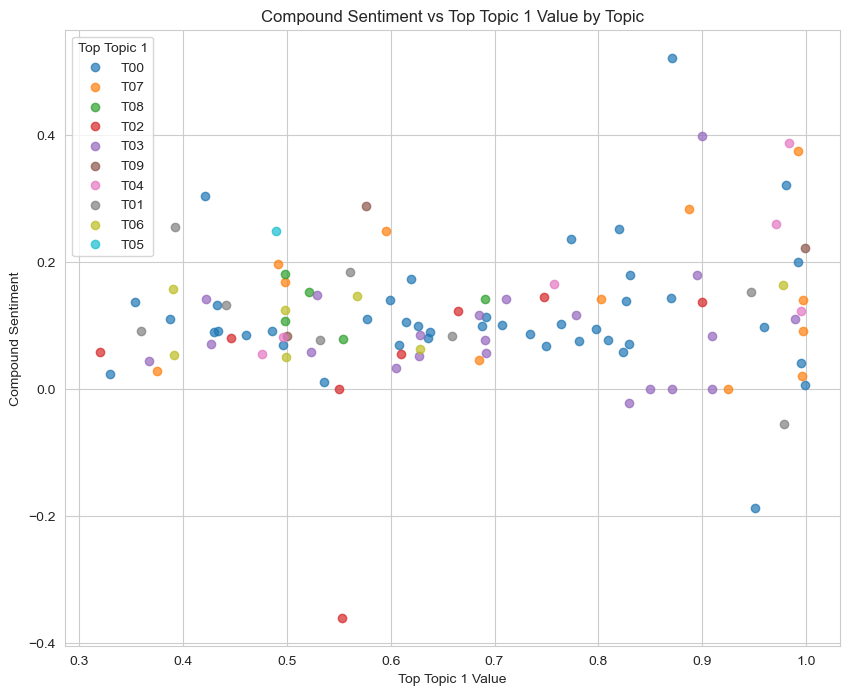

In [175]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

for topic in top_three_topics['top_topic_1'].unique():
    x = top_three_topics.loc[top_three_topics['top_topic_1'] == topic]['top_topic_1_value']
    y = top_three_topics.loc[top_three_topics['top_topic_1'] == topic]['compound']
    ax.scatter(x, y, label=topic, alpha=0.7)

ax.set_xlabel('Top Topic 1 Value')
ax.set_ylabel('Compound Sentiment')
ax.set_title('Compound Sentiment vs Top Topic 1 Value by Topic')
ax.legend(title='Top Topic 1')
plt.show()

In [176]:
unique_topic1 = top_three_topics['top_topic_1'].unique()
unique_topic1.sort()

for topic in unique_topic1:
    if topic == 'T05':
        continue
    topic_df = top_three_topics[top_three_topics['top_topic_1'] == topic]
    corr, _ = pearsonr(topic_df['top_topic_1_value'], topic_df['compound'])
    print(f'Pearson correlation for {topic}: {corr}')

Pearson correlation for T00: 0.0710157861388614
Pearson correlation for T01: -0.524474238361886
Pearson correlation for T02: 0.2869224616343338
Pearson correlation for T03: 0.1048294133866117
Pearson correlation for T04: 0.7317678387010147
Pearson correlation for T06: 0.38387381758034733
Pearson correlation for T07: 0.06414052295634762
Pearson correlation for T08: -0.05116120248148684
Pearson correlation for T09: 0.34422527357066557


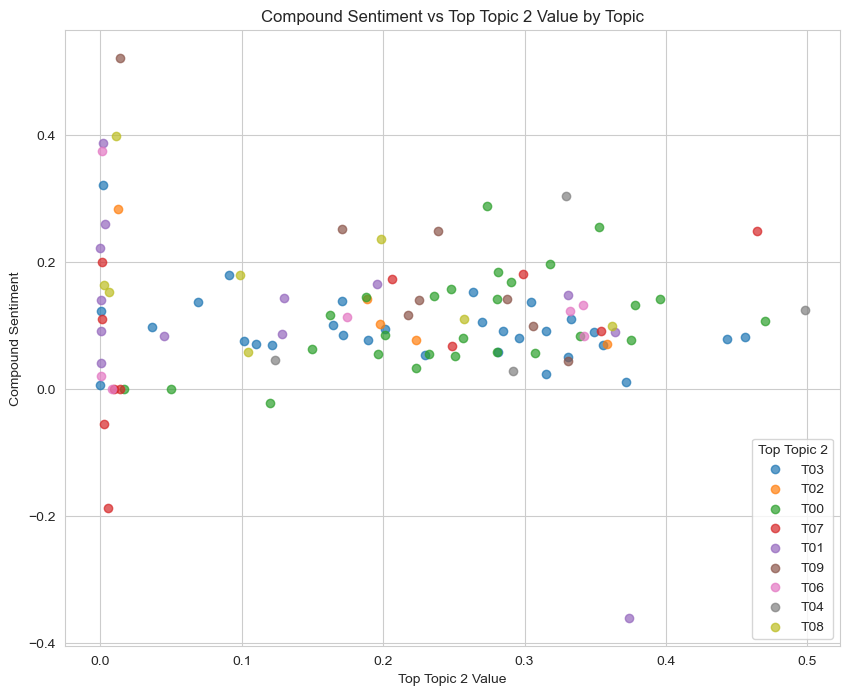

In [177]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

for topic in top_three_topics['top_topic_2'].unique():
    x = top_three_topics.loc[top_three_topics['top_topic_2'] == topic]['top_topic_2_value']
    y = top_three_topics.loc[top_three_topics['top_topic_2'] == topic]['compound']
    ax.scatter(x, y, label=topic, alpha=0.7)

ax.set_xlabel('Top Topic 2 Value')
ax.set_ylabel('Compound Sentiment')
ax.set_title('Compound Sentiment vs Top Topic 2 Value by Topic')
ax.legend(title='Top Topic 2')
plt.show()

In [178]:
unique_topic2 = top_three_topics['top_topic_2'].unique()
unique_topic2.sort()

for topic in unique_topic2:
    topic_df = top_three_topics[top_three_topics['top_topic_2'] == topic]
    corr, _ = pearsonr(topic_df['top_topic_2_value'], topic_df['compound'])
    print(f'Pearson correlation for {topic}: {corr}')

Pearson correlation for T00: 0.5075536395392479
Pearson correlation for T01: -0.5525259534354728
Pearson correlation for T02: -0.9118155886683602
Pearson correlation for T03: -0.3616320132221308
Pearson correlation for T04: 0.34284950278621096
Pearson correlation for T06: -0.08572822152818321
Pearson correlation for T07: 0.5944685733010919
Pearson correlation for T08: -0.4198119760240937
Pearson correlation for T09: -0.9374290479680917


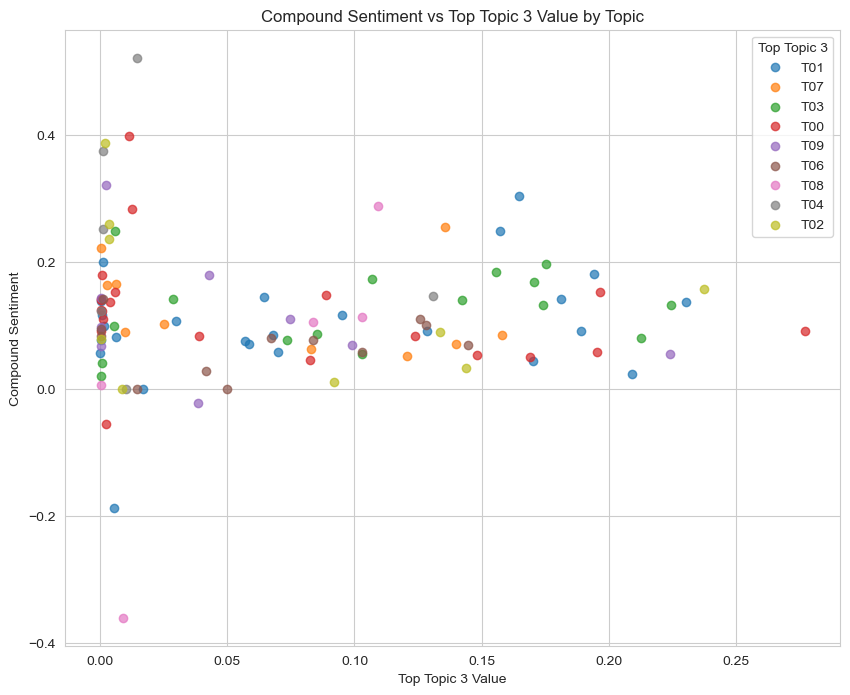

In [179]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

for topic in top_three_topics['top_topic_3'].unique():
    x = top_three_topics.loc[top_three_topics['top_topic_3'] == topic]['top_topic_3_value']
    y = top_three_topics.loc[top_three_topics['top_topic_3'] == topic]['compound']
    ax.scatter(x, y, label=topic, alpha=0.7)

ax.set_xlabel('Top Topic 3 Value')
ax.set_ylabel('Compound Sentiment')
ax.set_title('Compound Sentiment vs Top Topic 3 Value by Topic')
ax.legend(title='Top Topic 3')
plt.show()

In [180]:
unique_topic3 = top_three_topics['top_topic_3'].unique()
unique_topic3.sort()

for topic in unique_topic3:
    topic_df = top_three_topics[top_three_topics['top_topic_3'] == topic]
    corr, _ = pearsonr(topic_df['top_topic_3_value'], topic_df['compound'])
    print(f'Pearson correlation for {topic}: {corr}')

Pearson correlation for T00: -0.2857032962205228
Pearson correlation for T01: 0.31412551742183453
Pearson correlation for T02: -0.3212657110360257
Pearson correlation for T03: 0.2625689040119496
Pearson correlation for T04: -0.20506218970283746
Pearson correlation for T06: 0.10833794336706418
Pearson correlation for T07: -0.2855068083767154
Pearson correlation for T08: 0.7783292837622908
Pearson correlation for T09: -0.3475172392810736


When the primary topic of a school district is LGBTQ+ Issues, "Critical Race Theory," Assessments and Performance, or Community Member Rights, they are more likely to have a positive sentiment. However, if the primary topic is School Staffing Problems, then the district is more likely to have a negative sentiment.

When the next important topic of a school district board meeting consists of General School Topics, LGBTQ+ Issues, or School Operations, there is generally a positive sentiment. However, if the secondary topics of the school board meeting consists of School Staffing, Community Member Rights, Mask Mandates, School Extracurriculars, or Assessments and Performance, there is more likely to be a negative sentiment.

With the 3rd most important topic of a school district, School Staffing Problems, Mask Mandates, and School Extracurriculars are more likely to be have a positive sentiment, but General School Topics, Community Member Rights, LGBTQ+ Issues, School Operations, as well as Assessments and Performance are more likely to have a negative sentiment.

Upfront, it's important to acknowledge that there is a clear statistical limitation with this approach. The ideal approach would identify the sentiment of each individual speaker and examine the extent to which that individual discusses a particular topic before drawing correlations with sentiment and topic. Unfortunately, our analyses are currently done at the district-level, so it would be out of the current scope of the research questions. Even so, the primary topic of discussion may still serve as a valuable tool: at minimum, the topic_1 was discussed as part of >30% of the mixture of topics up to nearly 100% of the mixture of topics. The majority of the sentiment is likely attributable to that particular topic - of course, it is very possible for all the positive sentiment to be tied to another topic beyond topic 1. Bringing in topic_2 helps alleviate some of those problems. Topic_3 may not add too much value.

It appears that LGBTQ+ Issues are associated with positive sentiments across school districts that featured those topics as the primary/secondary topic. This may be promising since LGBTQ+ groups have been under attack, so there may be some signal that people are willing to combat it and express positive sentiment toward LGBTQ+ groups. Other positive sentiments (ranging from weak to moderate) with the primary/secondary topic consist of General School Topics and School Operations. This may be in response to positive thoughts about what's currently happening in schools.

The only consistently negative topic between the primary/secondary topic is School Staffing problems, which makes sense given conversations around general shortages (teachers/substitutes/bus drivers). Other negative sentiments (ranging from weak to moderate) consist of School Extracurriculars. Although it is unclear a priori why that may be true, it may be possible that Extracurricular activities were impacted due to COVID-19 and the broader situation around Identity Politics.

(array([ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  1., 11., 25., 30., 21.,  7.,
         6.,  3.,  2.,  2.,  1.,  0.,  1.]),
 array([-0.36005  , -0.3159975, -0.271945 , -0.2278925, -0.18384  ,
        -0.1397875, -0.095735 , -0.0516825, -0.00763  ,  0.0364225,
         0.080475 ,  0.1245275,  0.16858  ,  0.2126325,  0.256685 ,
         0.3007375,  0.34479  ,  0.3888425,  0.432895 ,  0.4769475,
         0.521    ]),
 <BarContainer object of 20 artists>)

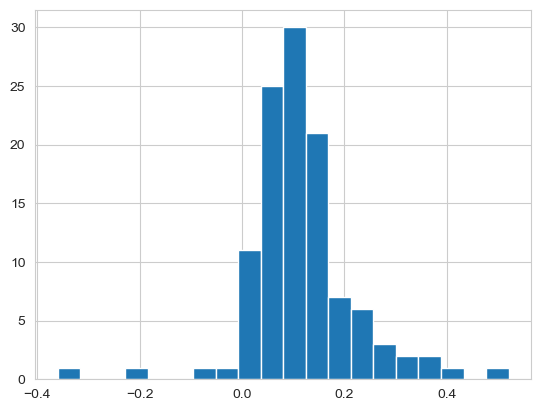

In [181]:
plt.hist(top_three_topics['compound'], bins = 20)

### Saving Files

In [182]:
TRANSCRIPT_DISTRICT_ID_SENTIMENT = top_three_topics

In [183]:
TRANSCRIPT_DISTRICT_ID_SENTIMENT.to_csv(f"{table_home}/TRANSCRIPT_DISTRICT_ID_SENTIMENT.csv", index=True)
TRANSCRIPT_DICTIONARY_LEXICONS.to_csv(f"{table_home}/TRANSCRIPT_DICTIONARY_LEXICONS.csv", index=True)

# Saving Updated CORPUS, LIBRARY, and VOCAB

In [184]:
TRANSCRIPT_LIB.to_csv(f"{table_home}/TRANSCRIPT_LIB_SUBMISSION.csv", index=True)
TRANSCRIPT_CORPUS.to_csv(f"{table_home}/TRANSCRIPT_CORPUS_SUBMISSION.csv", index=True)
TRANSCRIPT_VOCAB.to_csv(f"{table_home}/TRANSCRIPT_VOCAB_SUBMISSION.csv", index=True)